In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import bicgstab
import Reader as rd
from glob import glob
import matplotlib.patches as patches
import pandas as pd
import math
from scipy.misc import imread


import os

#### Methods

In [2]:
def e_neighbour_graph(img, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            result[row * colN + col][(row + rowDiff) * colN + (col + colDiff)] = 1
    return result


def fully_connected_graph(img, sigma):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for row2 in range(rowN):
                for col2 in range(colN):
                    weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                    result[row * colN + col][row2 * colN + col2] = weight
    return result


def fully_connected_e_neighbour_graph(img, sigma, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            row2 = row + rowDiff
                            col2 = col + colDiff
                            weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                            result[row * colN + col][row2 * colN + col2] = weight
    return result
'''
# Check for graph implementations
ANGLE = 0 # 0-15, 0 is front, 8 is back
path_list = glob("./stage1_aps/*.aps")
path = path_list[0]
data = rd.read_data(path_list[0])
# we only get images from one certain angle
# img = np.rot90(data[:,:, ANGLE])
# imgplt = plt.imshow(img)
plt.show()


img2 = imread("./sample.jpg")
img2 = np.asarray(img2,np.dtype(np.int32))
# plt.imshow(img2)
# plt.show()
A = np.array([[1,2,3], [0,5,6]])
# A = img2
print("Image")
print(np.shape(A))
print(A)
print("e neighbour graph")
print(e_neighbour_graph(A, 1))
print("Fully connected & e neighbour graph")
print(np.round(fully_connected_e_neighbour_graph(A, 1, 1), decimals=2))
print("Fully connected graph")
print(np.round(fully_connected_graph(A, 1), decimals=2))
'''


def laplacian(graph):
    diag = np.diag(sum(graph))
    lap = diag - graph
    return [lap, diag]


def orthogonalize(diag, s):
    nodeNum = len(diag)
    p = np.ones((nodeNum, 1)) / pow(sum(np.diag(np.diag(sum(diag)))), .5)
    projection = np.dot(np.transpose(s), np.dot(diag, p))
    v = s - projection[0][0] * p
    # return [v, projection]
    return v


def PRwalk(graph, alpha, s):
    if alpha < 0:
        print('Error: alpha must be positive!')
        return -1
    nodeNum = len(graph)
    [L, D] = laplacian(graph)
    s = orthogonalize(D, s)
    v, flag = bicgstab((L + alpha * D), np.dot(D, s),tol=1e-3, maxiter=nodeNum)

    v = np.reshape(v, (len(v), 1))

    v = orthogonalize(D, v)
    return v

# Check for method implementations
# A = np.array([[1, 2, 3], [1, 5, 6]])
# G = np.round(fully_connected_e_neighbour_graph(A, 10, 1), decimals=1)
# print("Laplacian Check")
# [L, D] = laplacian(G)
# print(L)
# print(D)
# print("Orthogonalize check")
# A = np.array([2,3,3])
# D = np.diag(A)
# s = np.array([[1], [2], [3]])
# t = orthogonalize(D, s)
# print(t)
# print("PRwalk check")
# G = np.array([[0, 1], [1, 0]])
# s = np.array([[1], [2]])
# print(PRwalk(G, 1, s)) # output should be [[-0.167], [ 0.167]]

def normalize(D, s):
    norm = np.dot(np.dot(np.transpose(s), D), s)
    v = s/math.sqrt(norm)
    return v


#### Image

In [3]:
# 1a10297e6c3101af33003e6c4f846f47
IMAGE = "1a10297e6c3101af33003e6c4f846f47"
myImg = np.asarray(imread(IMAGE + "/" + IMAGE + ".aps.jpg"), dtype=np.int)
# print(myImg)
# print(myImg.shape) # 148 row, 176 columns
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
# seed[40 * myImg.shape[1] + 90][0] = 1 # Example seed
# seed[74 * myImg.shape[1] + 88][0] = 1 # Example middle seed
seedList = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1', [40,90],[40,65],[45,123],[30,100]]
for i in range(25, 122, 48):
    for j in range(60, 125, 32):
        seedList.append([i,j])
alphaListList = []
correlationListList = []
scoreListList = []
valueListList = []

#### Trying seed as normalised full image

$seed[i] = \frac{intensity[i]}{\sqrt{\sum intensity^2}}$

In [4]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed / math.sqrt(sum(sum(seed * seed)))

[L, D] = laplacian(graph)
s = orthogonalize(D, seed)
s = normalize(D, s)
exponential = 0
alpha = 2 ** exponential
v = PRwalk(graph, alpha, s)
normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
# print(normalization)
correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]

print('Threshold: ' + str(1 / len(graph)))
alphaList = []
alphaList.append(alpha)

correlationList = []
correlationList.append(correlation)
      
scoreList = []
scoreList.append(score)

valueList = []
valueList.append(v)
print('')
print('alpha: 2^' + str(exponential))
print('Correlation: ' + str(correlation))
print('Score: ' + str(score))

maxIterations = 29
minIterations = 3
for i in range(maxIterations):
    if correlation > 1 / len(graph):
        oldCorrelation = correlation
        exponential -= 1
        alpha = 2 ** exponential
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
        alphaList.append(alpha)
        correlationList.append(correlation)
        scoreList.append(score)
        valueList.append(v)
        print('')
        print('alpha: 2^' + str(exponential))
        print('Correlation: ' + str(correlation))
        print('Score: ' + str(score))
    if i == minIterations:
        print('')
        print('Starting correlation decrease check!')
    if i >= minIterations and oldCorrelation * .99 < correlation:
        break

alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.999609277212
Score: 0.00284619627768

alpha: 2^-1
Correlation: 0.999100221702
Score: 0.00249159658409

alpha: 2^-2
Correlation: 0.998186253305
Score: 0.00216857517055

alpha: 2^-3
Correlation: 0.996669527778
Score: 0.00189847414363

alpha: 2^-4
Correlation: 0.994198397598
Score: 0.00167644078187

Starting correlation decrease check!


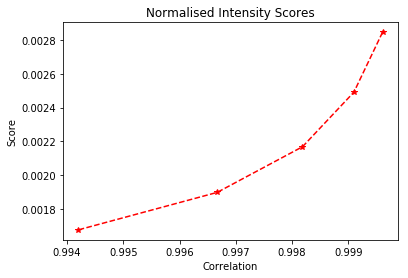

In [5]:
plt.plot(correlationList, scoreList, 'r*--')
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

Plotting each heat map
Score: 0.00284619627768
Heatmap:



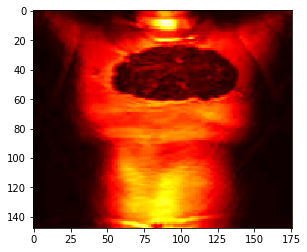

Score: 0.00249159658409
Heatmap:



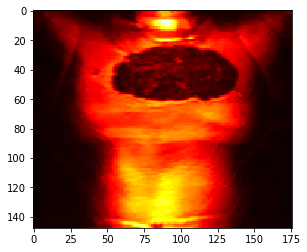

Score: 0.00216857517055
Heatmap:



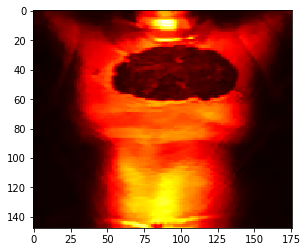

Score: 0.00189847414363
Heatmap:



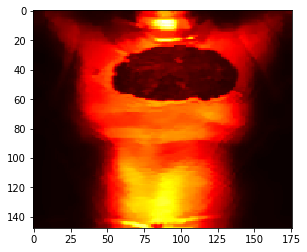

Score: 0.00167644078187
Heatmap:



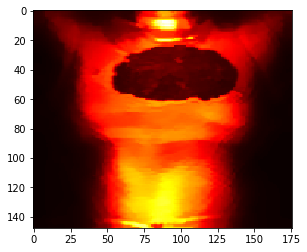

In [9]:
print('Plotting each heat map')
for item in range(len(valueList)):
    heat = np.zeros(myImg.shape)
    for i in range(myImg.shape[0]):
        for j in range(myImg.shape[1]):
            heat[i][j] = valueList[item][i * myImg.shape[1] + j]
    print('Score: ' + str(scoreList[item]))
    print('Heatmap:\n')
    plt.imshow(heat, cmap='hot', interpolation='nearest')
    # plt.imshow(heat, cmap='hot', interpolation='nearest',alpha = .6)
    plt.show()

#### Trying seed as normalised Intensity Square to between 0 and 1

$seed[i] = \frac{intensity[i]^2 - min(intensity^2)}{max(intensity^2) - min(intensity^2)}$

In [28]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed * seed
seed = (seed - min(seed)) / (max(seed) - min(seed))

[L, D] = laplacian(graph)
s = orthogonalize(D, seed)
s = normalize(D, s)
exponential = 0
alpha = 2 ** exponential
v = PRwalk(graph, alpha, s)
normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
# print(normalization)
correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]

print('Threshold: ' + str(1 / len(graph)))
alphaList = []
alphaList.append(alpha)

correlationList = []
correlationList.append(correlation)
      
scoreList = []
scoreList.append(score)

valueList = []
valueList.append(v)
print('')
print('alpha: 2^' + str(exponential))
print('Correlation: ' + str(correlation))
print('Score: ' + str(score))

maxIterations = 29
minIterations = 3
for i in range(maxIterations):
    if correlation > 1 / len(graph):
        oldCorrelation = correlation
        exponential -= 1
        alpha = 2 ** exponential
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
        alphaList.append(alpha)
        correlationList.append(correlation)
        scoreList.append(score)
        valueList.append(v)
        print('')
        print('alpha: 2^' + str(exponential))
        print('Correlation: ' + str(correlation))
        print('Score: ' + str(score))
    if i == minIterations:
        print('')
        print('Starting correlation decrease check!')
    if i >= minIterations and oldCorrelation * .99 < correlation:
        break

alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.999462646036
Score: 0.00376256947974

alpha: 2^-1
Correlation: 0.998750297027
Score: 0.00326426888037

alpha: 2^-2
Correlation: 0.997429003009
Score: 0.00279753860944

alpha: 2^-3
Correlation: 0.995123171349
Score: 0.00238673896867

alpha: 2^-4
Correlation: 0.991180414718
Score: 0.00203073896722

Starting correlation decrease check!


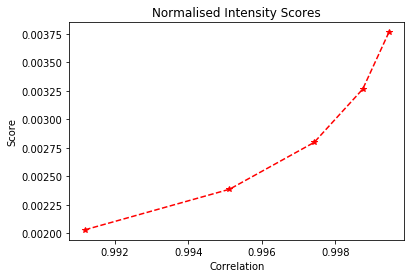

In [29]:
plt.plot(correlationList, scoreList, 'r*--')
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

Plotting each heat map
Score: 0.00376256947974
Heatmap:



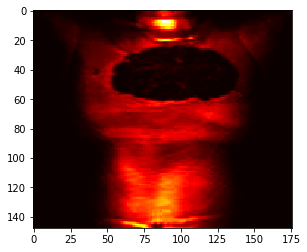

Score: 0.00326426888037
Heatmap:



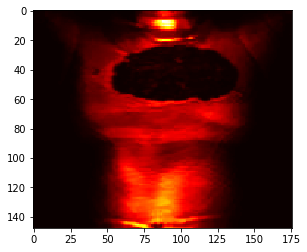

Score: 0.00279753860944
Heatmap:



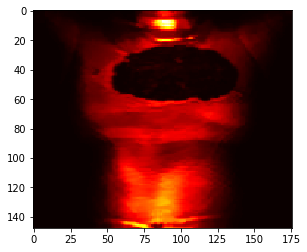

Score: 0.00238673896867
Heatmap:



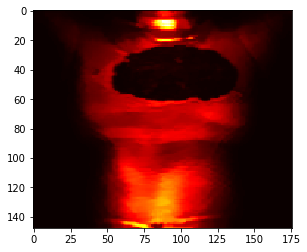

Score: 0.00203073896722
Heatmap:



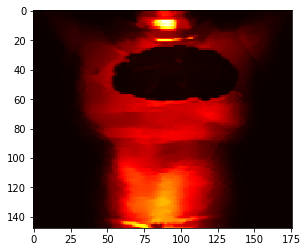

In [30]:
print('Plotting each heat map')
for item in range(len(valueList)):
    heat = np.zeros(myImg.shape)
    for i in range(myImg.shape[0]):
        for j in range(myImg.shape[1]):
            heat[i][j] = valueList[item][i * myImg.shape[1] + j]
    print('Score: ' + str(scoreList[item]))
    print('Heatmap:\n')
    plt.imshow(heat, cmap='hot', interpolation='nearest')
    # plt.imshow(heat, cmap='hot', interpolation='nearest',alpha = .6)
    plt.show()

#### Trying seedList that is randomly taken in and outside of threat

--------Seed [40, 90]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.979509808791
Score: 0.846963786643

alpha: 2^-1
Correlation: 0.946911477422
Score: 0.795829431707

alpha: 2^-2
Correlation: 0.882322357777
Score: 0.717909408462

alpha: 2^-3
Correlation: 0.775766690166
Score: 0.610198996165

alpha: 2^-4
Correlation: 0.628033869137
Score: 0.477383665113

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.458988170279
Score: 0.337137000658

alpha: 2^-6
Correlation: 0.2973519427
Score: 0.210740403305

alpha: 2^-7
Correlation: 0.164514024058
Score: 0.111756804487

alpha: 2^-8
Correlation: 0.0763552714362
Score: 0.0489790533935

alpha: 2^-9
Correlation: 0.0310263836821
Score: 0.018304246976

alpha: 2^-10
Correlation: 0.0127295214906
Score: 0.00671109975807

alpha: 2^-11
Correlation: 0.0059406158583
Score: 0.00276482724251

alpha: 2^-12
Correlation: 0.0033740075994
Score: 0.00141752628092

alpha: 2^-13
Correlation: 0.00229314854973
Score: 0.000904902133787

alpha:

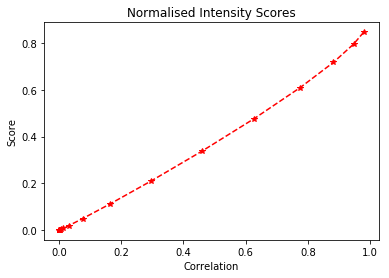

Plotting each heat map
Score: 0.846963786643
Heatmap:



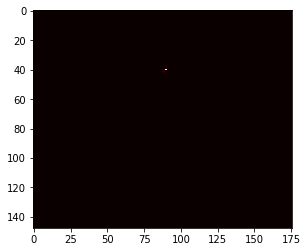

Score: 0.795829431707
Heatmap:



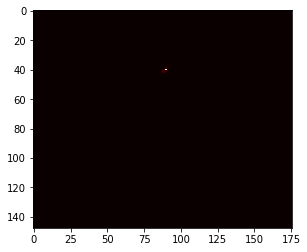

Score: 0.717909408462
Heatmap:



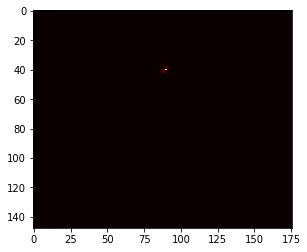

Score: 0.610198996165
Heatmap:



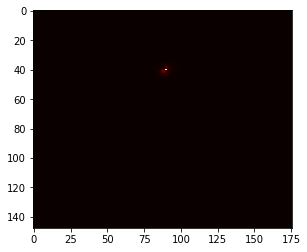

Score: 0.477383665113
Heatmap:



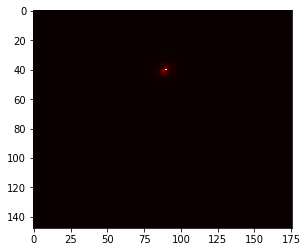

Score: 0.337137000658
Heatmap:



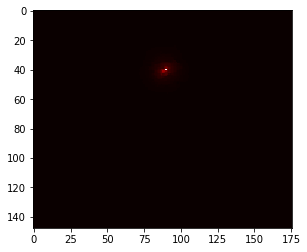

Score: 0.210740403305
Heatmap:



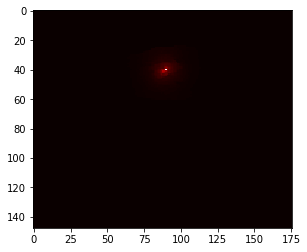

Score: 0.111756804487
Heatmap:



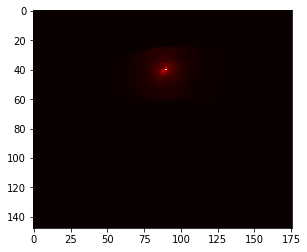

Score: 0.0489790533935
Heatmap:



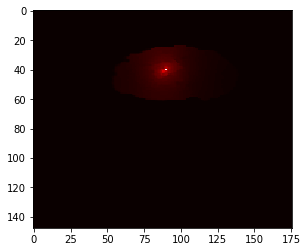

Score: 0.018304246976
Heatmap:



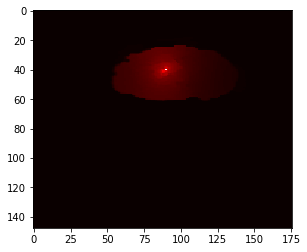

Score: 0.00671109975807
Heatmap:



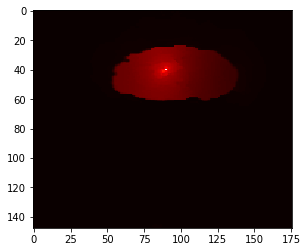

Score: 0.00276482724251
Heatmap:



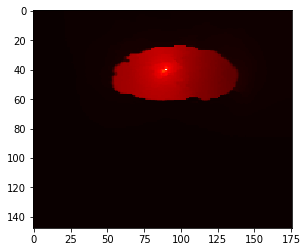

Score: 0.00141752628092
Heatmap:



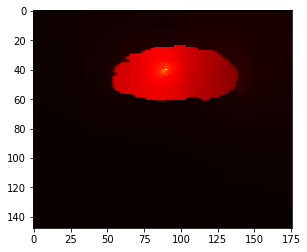

Score: 0.000904902133787
Heatmap:



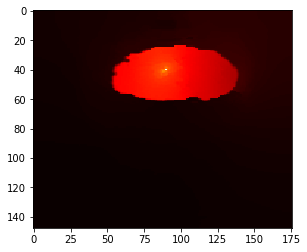

Score: 0.000698094628287
Heatmap:



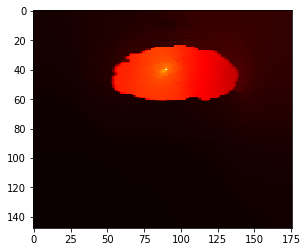

Score: 0.000603889855239
Heatmap:



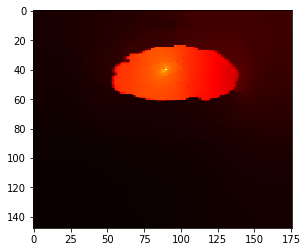

Score: 0.000559528269246
Heatmap:



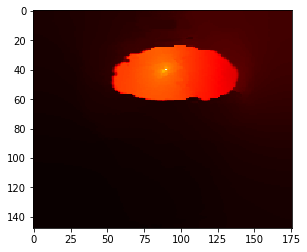

Score: 0.000537097292953
Heatmap:



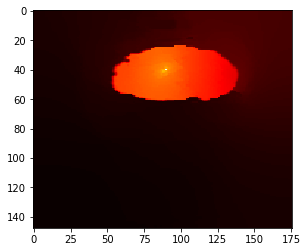

Score: 0.000526232116708
Heatmap:



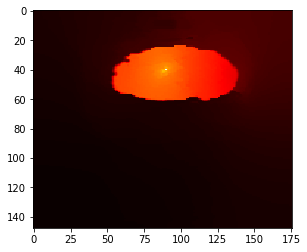

Score: 0.000518486496471
Heatmap:



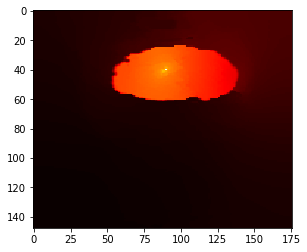

Score: 0.000520050825737
Heatmap:



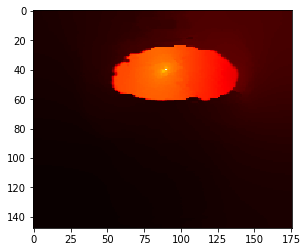

--------Seed [40, 65]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.977513063251
Score: 0.862859535467

alpha: 2^-1
Correlation: 0.940954381883
Score: 0.804893110868

alpha: 2^-2
Correlation: 0.866748650947
Score: 0.71420169046

alpha: 2^-3
Correlation: 0.736337437891
Score: 0.580761223698

alpha: 2^-4
Correlation: 0.547593541935
Score: 0.409798820028

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.34291480784
Score: 0.240525346448

alpha: 2^-6
Correlation: 0.183876630156
Score: 0.118974676195

alpha: 2^-7
Correlation: 0.0900789668509
Score: 0.0527653662126

alpha: 2^-8
Correlation: 0.0437556130384
Score: 0.0228294189321

alpha: 2^-9
Correlation: 0.0220305278358
Score: 0.0101283033973

alpha: 2^-10
Correlation: 0.0117277756772
Score: 0.0047363665522

alpha: 2^-11
Correlation: 0.00646613472898
Score: 0.00229332112812

alpha: 2^-12
Correlation: 0.00403559917304
Score: 0.00129618765317

alpha: 2^-13
Correlation: 0.00292366139462
Score: 0.000887478586246

al

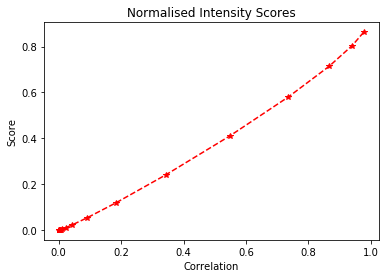

Plotting each heat map
Score: 0.862859535467
Heatmap:



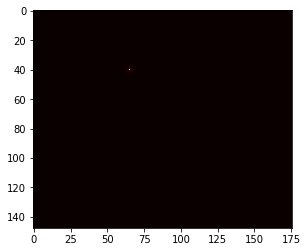

Score: 0.804893110868
Heatmap:



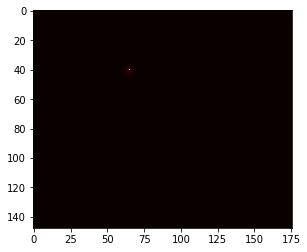

Score: 0.71420169046
Heatmap:



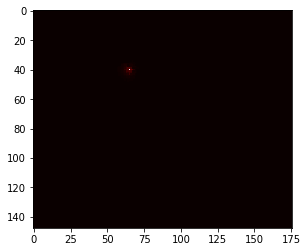

Score: 0.580761223698
Heatmap:



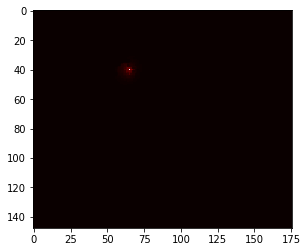

Score: 0.409798820028
Heatmap:



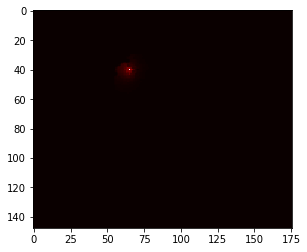

Score: 0.240525346448
Heatmap:



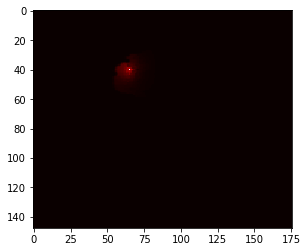

Score: 0.118974676195
Heatmap:



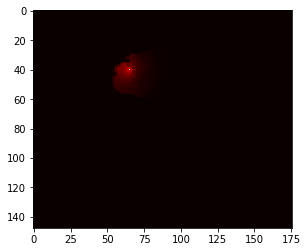

Score: 0.0527653662126
Heatmap:



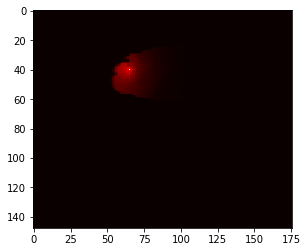

Score: 0.0228294189321
Heatmap:



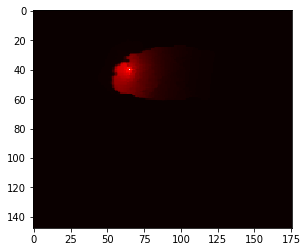

Score: 0.0101283033973
Heatmap:



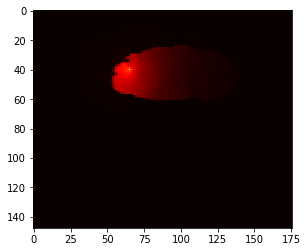

Score: 0.0047363665522
Heatmap:



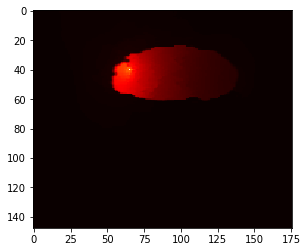

Score: 0.00229332112812
Heatmap:



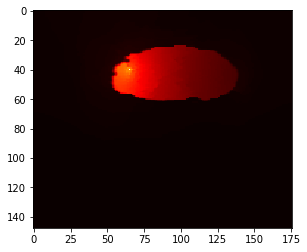

Score: 0.00129618765317
Heatmap:



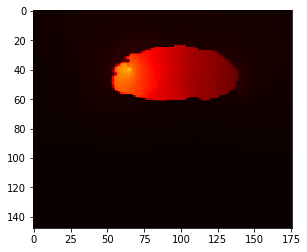

Score: 0.000887478586246
Heatmap:



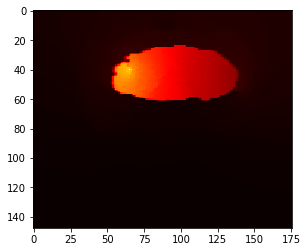

Score: 0.0006907151825
Heatmap:



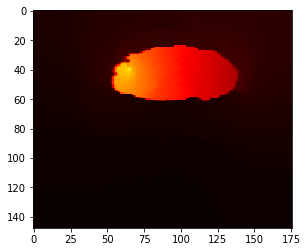

Score: 0.000608785430571
Heatmap:



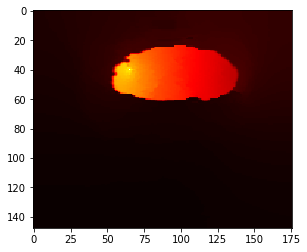

Score: 0.000560078476512
Heatmap:



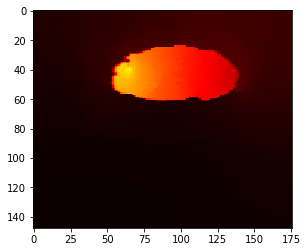

Score: 0.00055081647761
Heatmap:



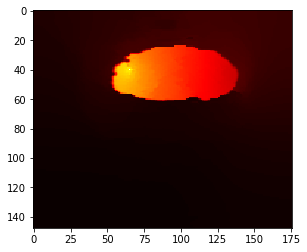

Score: 0.000535486911663
Heatmap:



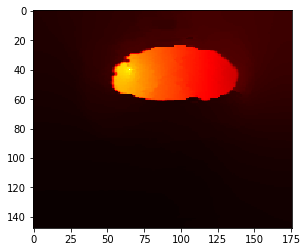

Score: 0.000530465695973
Heatmap:



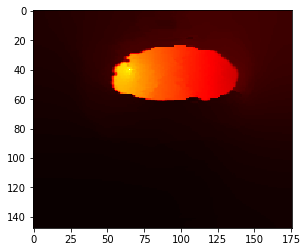

--------Seed [45, 123]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.977487136622
Score: 0.879804067723

alpha: 2^-1
Correlation: 0.938024923072
Score: 0.816671134172

alpha: 2^-2
Correlation: 0.854351888582
Score: 0.713104587714

alpha: 2^-3
Correlation: 0.715188857035
Score: 0.568689292043

alpha: 2^-4
Correlation: 0.539403212166
Score: 0.407502163556

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.361948235247
Score: 0.259150183726

alpha: 2^-6
Correlation: 0.208164534835
Score: 0.139877130738

alpha: 2^-7
Correlation: 0.103347905429
Score: 0.0640164614487

alpha: 2^-8
Correlation: 0.0478764841881
Score: 0.0267453464056

alpha: 2^-9
Correlation: 0.022119855675
Score: 0.0108981797092

alpha: 2^-10
Correlation: 0.0113656867882
Score: 0.00492507423704

alpha: 2^-11
Correlation: 0.00590665367487
Score: 0.00221803052485

alpha: 2^-12
Correlation: 0.00354489529985
Score: 0.00118774917456

alpha: 2^-13
Correlation: 0.00248210159466
Score: 0.000776241287156



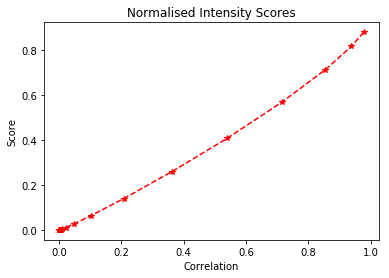

Plotting each heat map
Score: 0.879804067723
Heatmap:



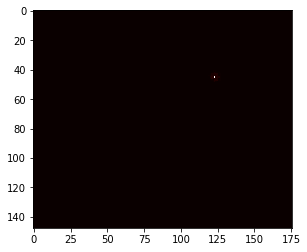

Score: 0.816671134172
Heatmap:



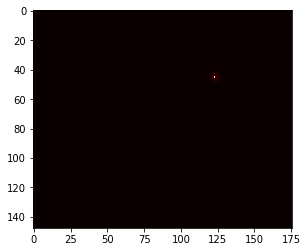

Score: 0.713104587714
Heatmap:



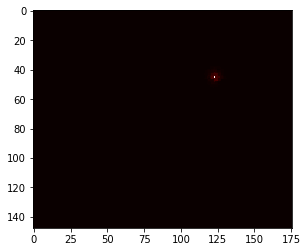

Score: 0.568689292043
Heatmap:



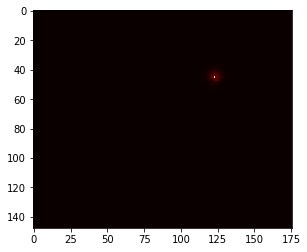

Score: 0.407502163556
Heatmap:



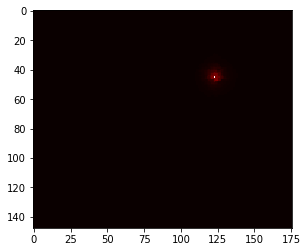

Score: 0.259150183726
Heatmap:



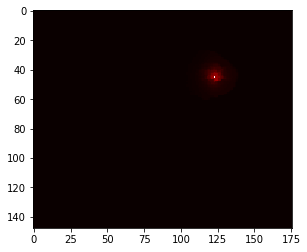

Score: 0.139877130738
Heatmap:



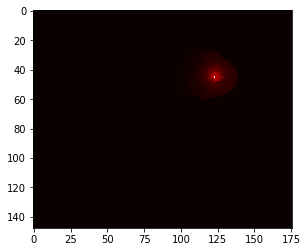

Score: 0.0640164614487
Heatmap:



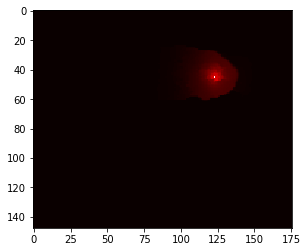

Score: 0.0267453464056
Heatmap:



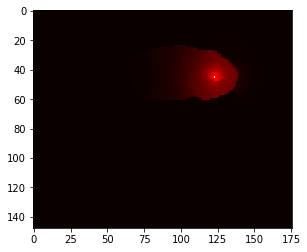

Score: 0.0108981797092
Heatmap:



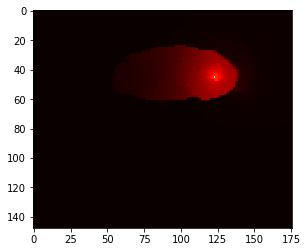

Score: 0.00492507423704
Heatmap:



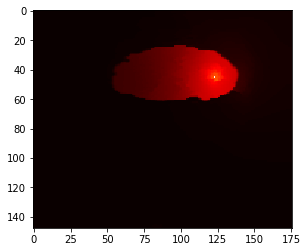

Score: 0.00221803052485
Heatmap:



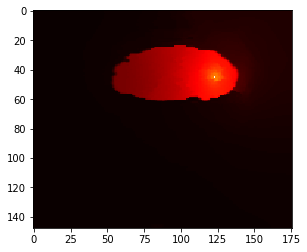

Score: 0.00118774917456
Heatmap:



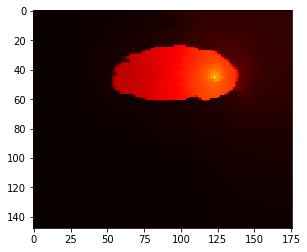

Score: 0.000776241287156
Heatmap:



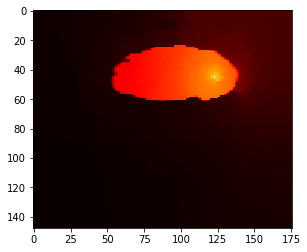

Score: 0.000598357438949
Heatmap:



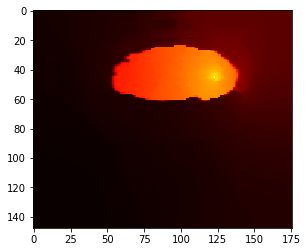

Score: 0.000519813150283
Heatmap:



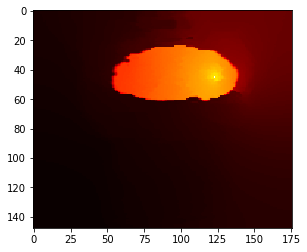

Score: 0.000480192941598
Heatmap:



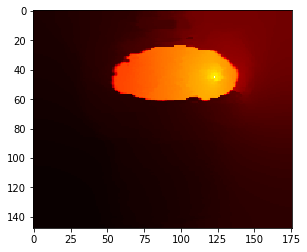

Score: 0.000466435918368
Heatmap:



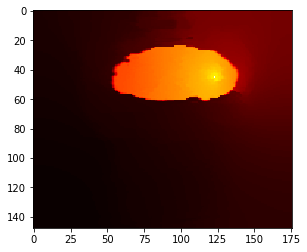

Score: 0.000457658033839
Heatmap:



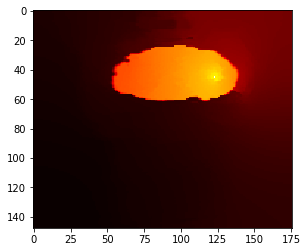

Score: 0.000460436369163
Heatmap:



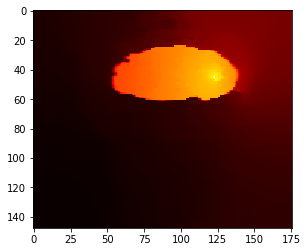

--------Seed [30, 100]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.978329207884
Score: 0.865353679424

alpha: 2^-1
Correlation: 0.941299481312
Score: 0.80665828434

alpha: 2^-2
Correlation: 0.862179922231
Score: 0.709906924688

alpha: 2^-3
Correlation: 0.723478135357
Score: 0.567945819046

alpha: 2^-4
Correlation: 0.533935015083
Score: 0.396536962413

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.342969268999
Score: 0.239231261628

alpha: 2^-6
Correlation: 0.200183145784
Score: 0.130572020641

alpha: 2^-7
Correlation: 0.110924996922
Score: 0.0674814085925

alpha: 2^-8
Correlation: 0.0577454359405
Score: 0.0325241973923

alpha: 2^-9
Correlation: 0.0275042337069
Score: 0.0140778928677

alpha: 2^-10
Correlation: 0.0126692551648
Score: 0.0057495346853

alpha: 2^-11
Correlation: 0.00620779348741
Score: 0.00246355789958

alpha: 2^-12
Correlation: 0.00361487370873
Score: 0.00128602836353

alpha: 2^-13
Correlation: 0.00249554733186
Score: 0.000831075270612

a

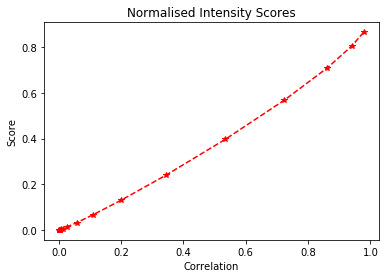

Plotting each heat map
Score: 0.865353679424
Heatmap:



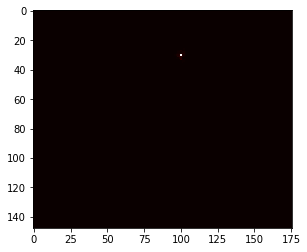

Score: 0.80665828434
Heatmap:



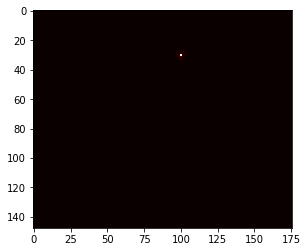

Score: 0.709906924688
Heatmap:



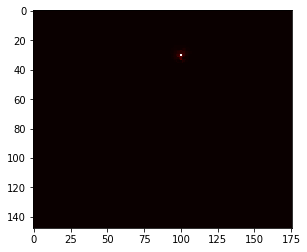

Score: 0.567945819046
Heatmap:



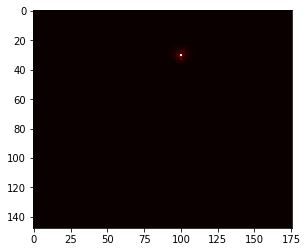

Score: 0.396536962413
Heatmap:



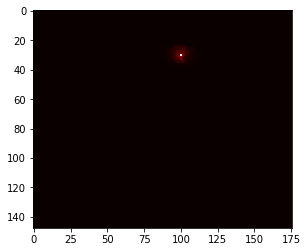

Score: 0.239231261628
Heatmap:



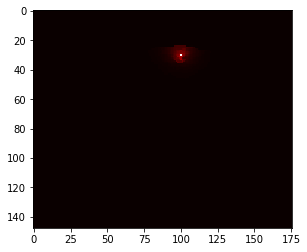

Score: 0.130572020641
Heatmap:



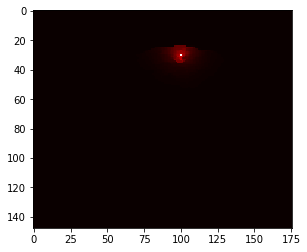

Score: 0.0674814085925
Heatmap:



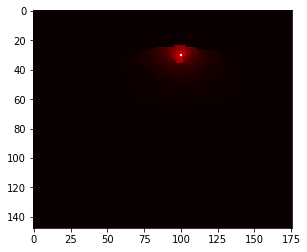

Score: 0.0325241973923
Heatmap:



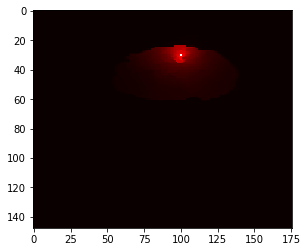

Score: 0.0140778928677
Heatmap:



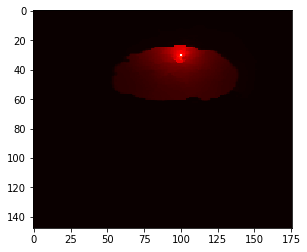

Score: 0.0057495346853
Heatmap:



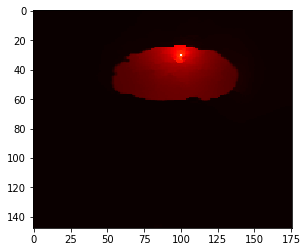

Score: 0.00246355789958
Heatmap:



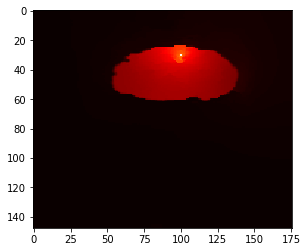

Score: 0.00128602836353
Heatmap:



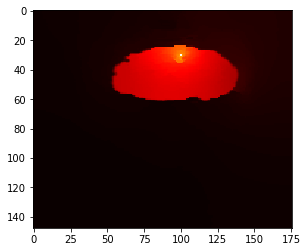

Score: 0.000831075270612
Heatmap:



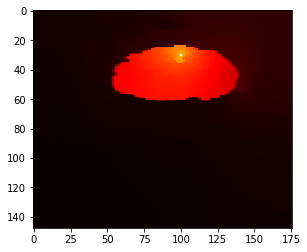

Score: 0.000643275210596
Heatmap:



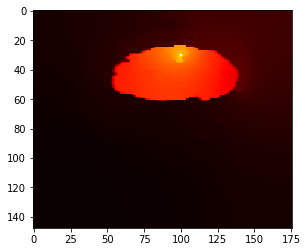

Score: 0.000556269529359
Heatmap:



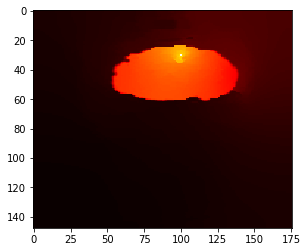

Score: 0.000517592506685
Heatmap:



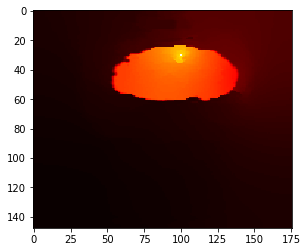

Score: 0.000495290559481
Heatmap:



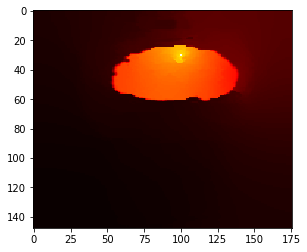

Score: 0.000492442615133
Heatmap:



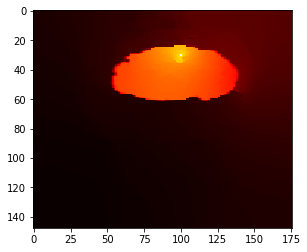

--------Seed [25, 60]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.970851073387
Score: 0.843245607292

alpha: 2^-1
Correlation: 0.920601584201
Score: 0.764075482367

alpha: 2^-2
Correlation: 0.819072593446
Score: 0.641725956469

alpha: 2^-3
Correlation: 0.664802078572
Score: 0.488149707165

alpha: 2^-4
Correlation: 0.489195169188
Score: 0.336159157605

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.329651502245
Score: 0.212258422873

alpha: 2^-6
Correlation: 0.20658848633
Score: 0.124850812634

alpha: 2^-7
Correlation: 0.122788977508
Score: 0.0697692098199

alpha: 2^-8
Correlation: 0.0703395115372
Score: 0.0376282090404

alpha: 2^-9
Correlation: 0.0398589143645
Score: 0.0201219177488

alpha: 2^-10
Correlation: 0.02231783883
Score: 0.0106457033643

alpha: 2^-11
Correlation: 0.01292013131
Score: 0.00585953627337

alpha: 2^-12
Correlation: 0.00820414084959
Score: 0.00358482397247

alpha: 2^-13
Correlation: 0.00583853431741
Score: 0.00249468852112

alpha: 2

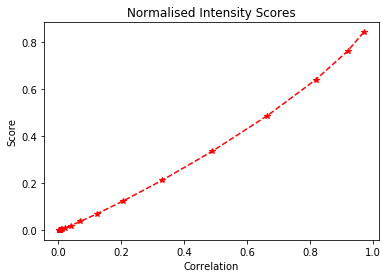

Plotting each heat map
Score: 0.843245607292
Heatmap:



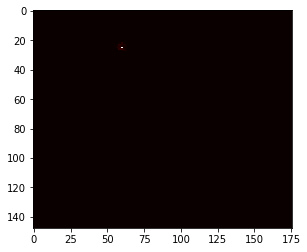

Score: 0.764075482367
Heatmap:



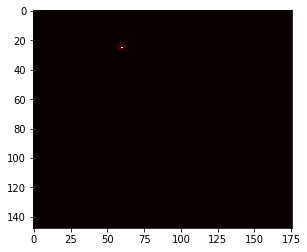

Score: 0.641725956469
Heatmap:



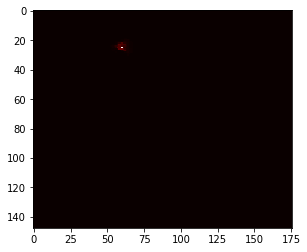

Score: 0.488149707165
Heatmap:



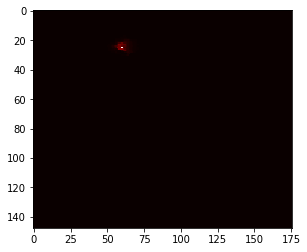

Score: 0.336159157605
Heatmap:



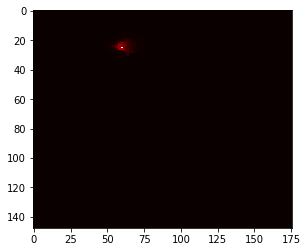

Score: 0.212258422873
Heatmap:



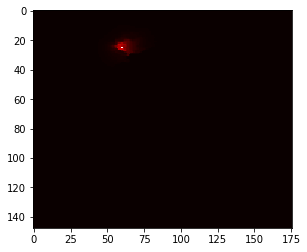

Score: 0.124850812634
Heatmap:



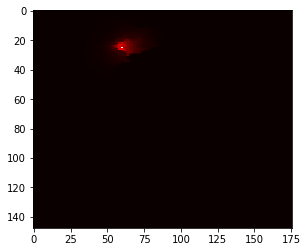

Score: 0.0697692098199
Heatmap:



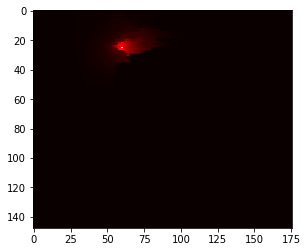

Score: 0.0376282090404
Heatmap:



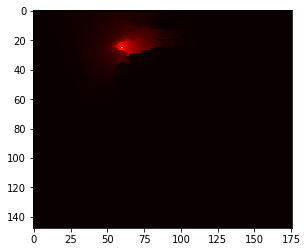

Score: 0.0201219177488
Heatmap:



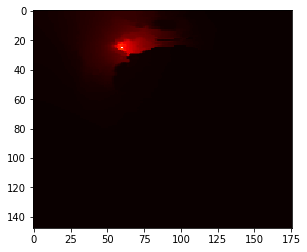

Score: 0.0106457033643
Heatmap:



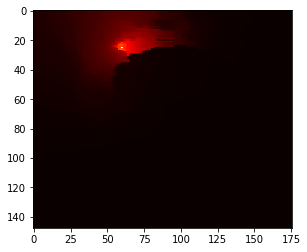

Score: 0.00585953627337
Heatmap:



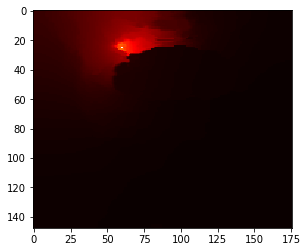

Score: 0.00358482397247
Heatmap:



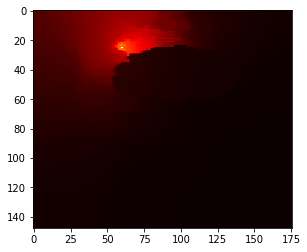

Score: 0.00249468852112
Heatmap:



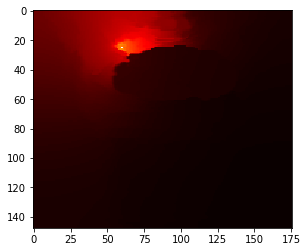

Score: 0.00194679814141
Heatmap:



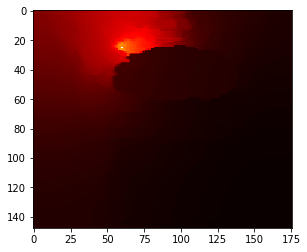

Score: 0.00167947380991
Heatmap:



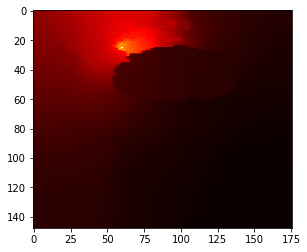

Score: 0.00156553149196
Heatmap:



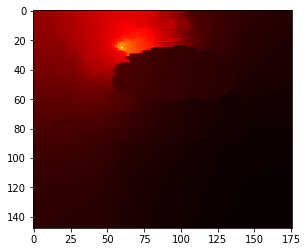

Score: 0.00150007212683
Heatmap:



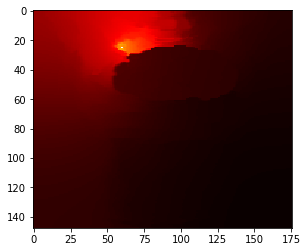

Score: 0.00146980255457
Heatmap:



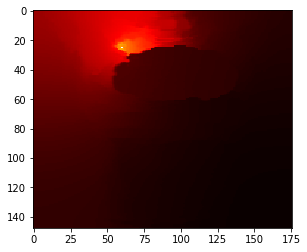

Score: 0.00144542328452
Heatmap:



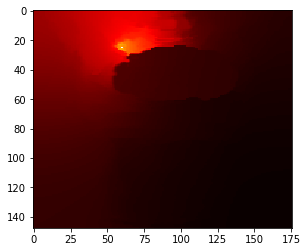

Score: 0.0014654473912
Heatmap:



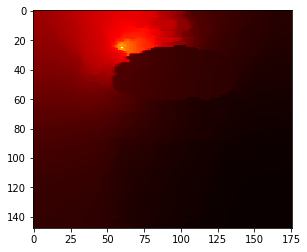

--------Seed [25, 92]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.977572456507
Score: 0.82574787259

alpha: 2^-1
Correlation: 0.941008139894
Score: 0.769185123155

alpha: 2^-2
Correlation: 0.865181040998
Score: 0.679378218399

alpha: 2^-3
Correlation: 0.73819334895
Score: 0.554209408236

alpha: 2^-4
Correlation: 0.569354574935
Score: 0.407560828737

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.392669708986
Score: 0.267585413924

alpha: 2^-6
Correlation: 0.244985490161
Score: 0.158757283756

alpha: 2^-7
Correlation: 0.141967619856
Score: 0.0874123367584

alpha: 2^-8
Correlation: 0.0765355902627
Score: 0.0446197580283

alpha: 2^-9
Correlation: 0.0372545931627
Score: 0.0203302403428

alpha: 2^-10
Correlation: 0.0166855144036
Score: 0.0083554989688

alpha: 2^-11
Correlation: 0.00791241247096
Score: 0.00359932323422

alpha: 2^-12
Correlation: 0.00435502386864
Score: 0.00182172222723

alpha: 2^-13
Correlation: 0.00288198283039
Score: 0.00114354062086

alph

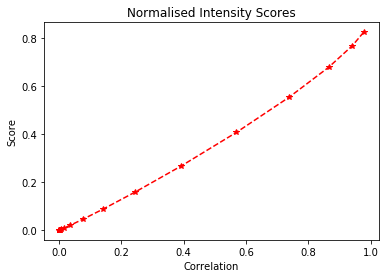

Plotting each heat map
Score: 0.82574787259
Heatmap:



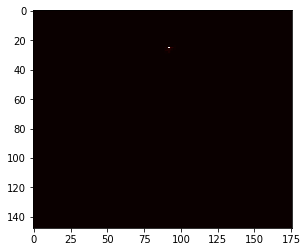

Score: 0.769185123155
Heatmap:



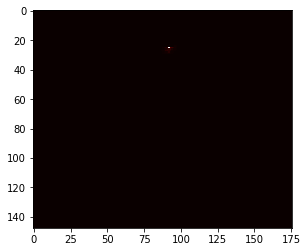

Score: 0.679378218399
Heatmap:



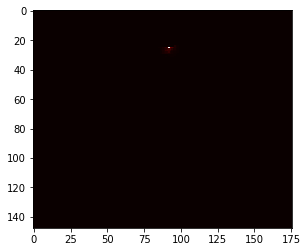

Score: 0.554209408236
Heatmap:



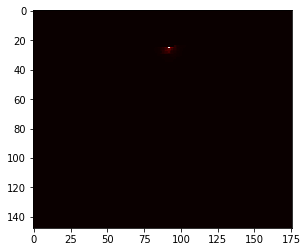

Score: 0.407560828737
Heatmap:



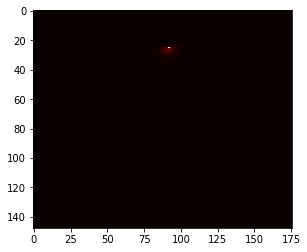

Score: 0.267585413924
Heatmap:



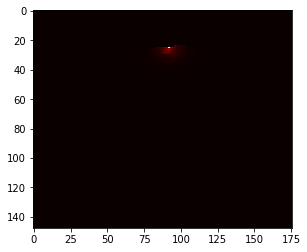

Score: 0.158757283756
Heatmap:



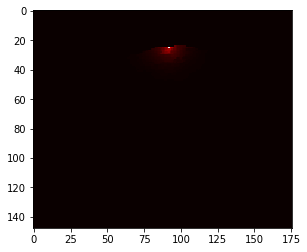

Score: 0.0874123367584
Heatmap:



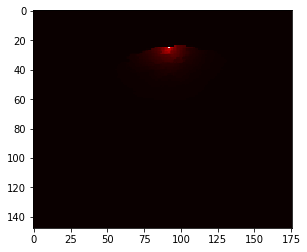

Score: 0.0446197580283
Heatmap:



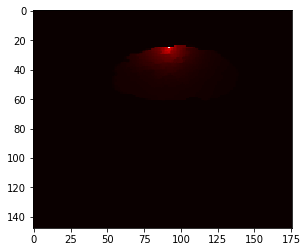

Score: 0.0203302403428
Heatmap:



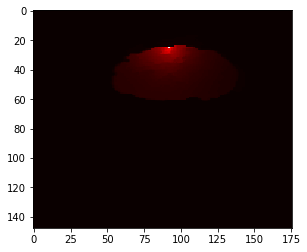

Score: 0.0083554989688
Heatmap:



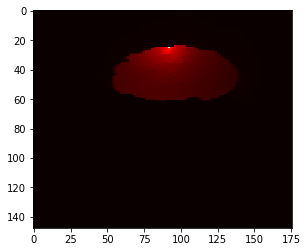

Score: 0.00359932323422
Heatmap:



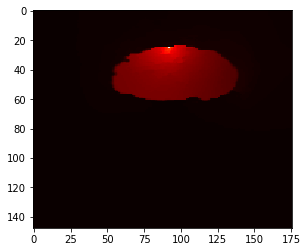

Score: 0.00182172222723
Heatmap:



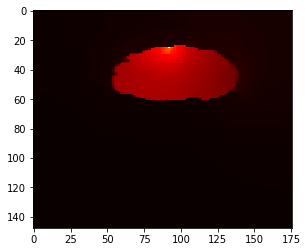

Score: 0.00114354062086
Heatmap:



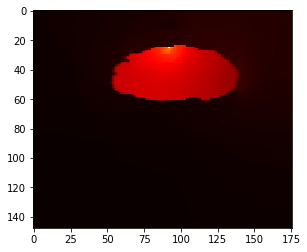

Score: 0.000852715594696
Heatmap:



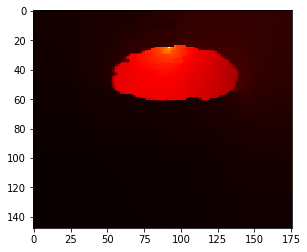

Score: 0.000734162928984
Heatmap:



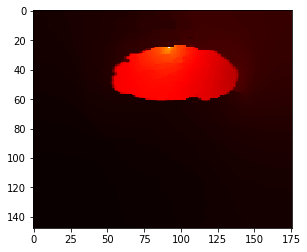

Score: 0.000668530911194
Heatmap:



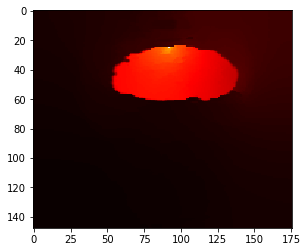

Score: 0.000642105078329
Heatmap:



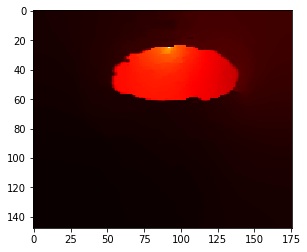

Score: 0.000629453055188
Heatmap:



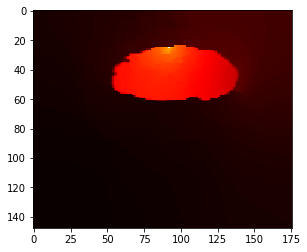

Score: 0.000617951366194
Heatmap:



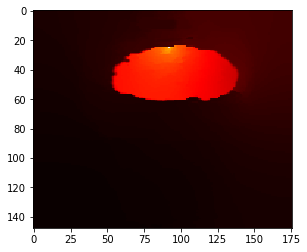

Score: 0.000614420329755
Heatmap:



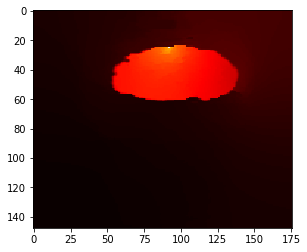

--------Seed [25, 124]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.976240126064
Score: 0.87236427894

alpha: 2^-1
Correlation: 0.933529702833
Score: 0.804310429555

alpha: 2^-2
Correlation: 0.839712311588
Score: 0.688969314982

alpha: 2^-3
Correlation: 0.681105832173
Score: 0.526261544792

alpha: 2^-4
Correlation: 0.484146704145
Score: 0.3490530679

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.304959660599
Score: 0.20379577729

alpha: 2^-6
Correlation: 0.178291971628
Score: 0.11008603142

alpha: 2^-7
Correlation: 0.101572712598
Score: 0.0579929744001

alpha: 2^-8
Correlation: 0.0573516977088
Score: 0.0303485118105

alpha: 2^-9
Correlation: 0.0317873331033
Score: 0.0155950063878

alpha: 2^-10
Correlation: 0.0172695457421
Score: 0.00784170269074

alpha: 2^-11
Correlation: 0.00974630573191
Score: 0.00411900693465

alpha: 2^-12
Correlation: 0.0060058227962
Score: 0.00239842752517

alpha: 2^-13
Correlation: 0.00415840516578
Score: 0.00160094920845

alpha:

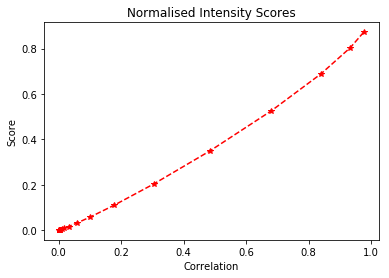

Plotting each heat map
Score: 0.87236427894
Heatmap:



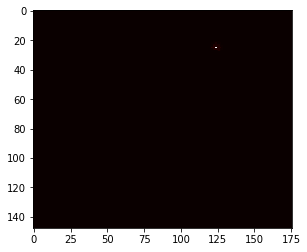

Score: 0.804310429555
Heatmap:



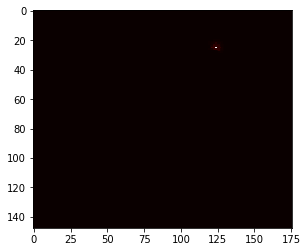

Score: 0.688969314982
Heatmap:



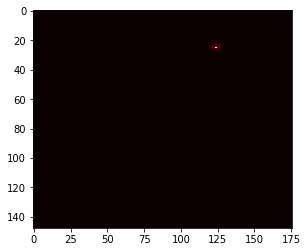

Score: 0.526261544792
Heatmap:



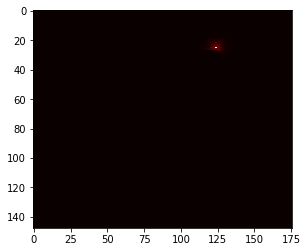

Score: 0.3490530679
Heatmap:



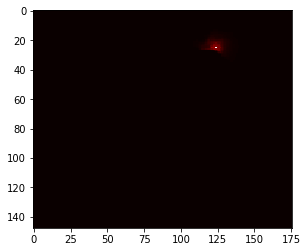

Score: 0.20379577729
Heatmap:



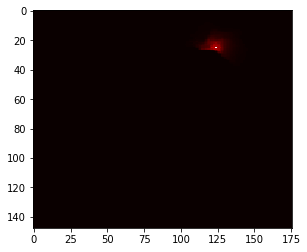

Score: 0.11008603142
Heatmap:



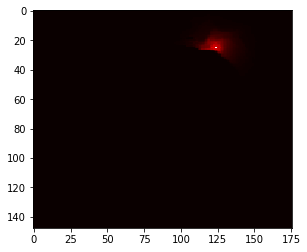

Score: 0.0579929744001
Heatmap:



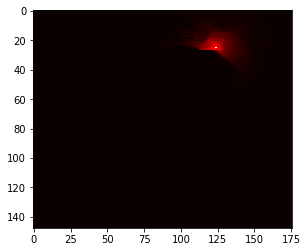

Score: 0.0303485118105
Heatmap:



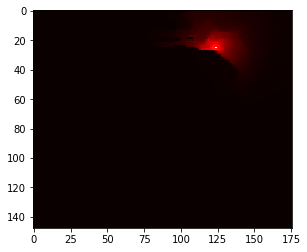

Score: 0.0155950063878
Heatmap:



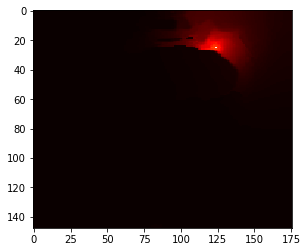

Score: 0.00784170269074
Heatmap:



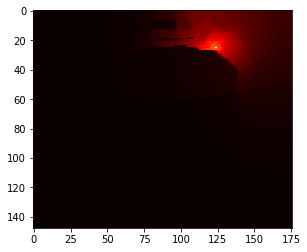

Score: 0.00411900693465
Heatmap:



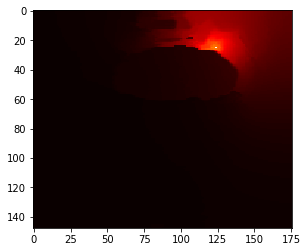

Score: 0.00239842752517
Heatmap:



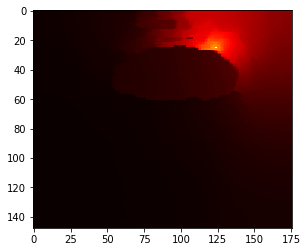

Score: 0.00160094920845
Heatmap:



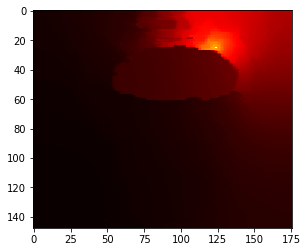

Score: 0.0012021145994
Heatmap:



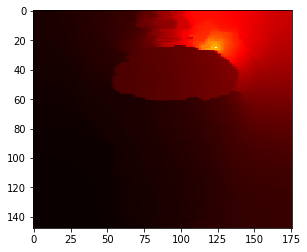

Score: 0.0010192657499
Heatmap:



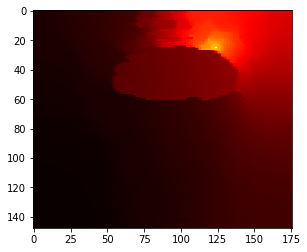

Score: 0.000944993499749
Heatmap:



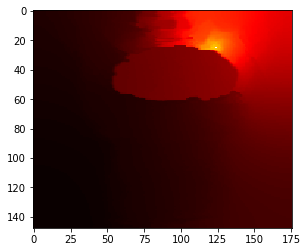

Score: 0.000883644044061
Heatmap:



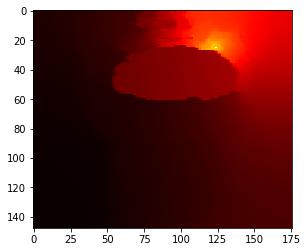

Score: 0.000857862739092
Heatmap:



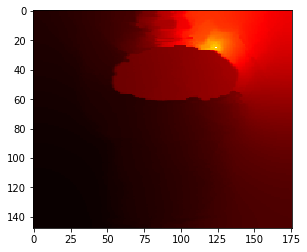

Score: 0.000850175386484
Heatmap:



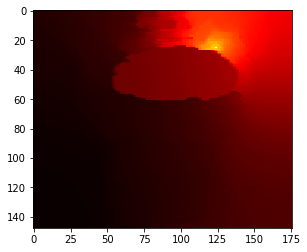

--------Seed [73, 60]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.979725721824
Score: 0.894780273

alpha: 2^-1
Correlation: 0.94297785681
Score: 0.835596387678

alpha: 2^-2
Correlation: 0.859782514296
Score: 0.731553510833

alpha: 2^-3
Correlation: 0.70940125274
Score: 0.573401868328

alpha: 2^-4
Correlation: 0.511781157659
Score: 0.3895077579

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.326369010625
Score: 0.232597764659

alpha: 2^-6
Correlation: 0.191799074297
Score: 0.12767161894

alpha: 2^-7
Correlation: 0.108588834508
Score: 0.0675231055088

alpha: 2^-8
Correlation: 0.0612981198084
Score: 0.0357136952604

alpha: 2^-9
Correlation: 0.0361162614422
Score: 0.019895936249

alpha: 2^-10
Correlation: 0.0231622612807
Score: 0.0122467886212

alpha: 2^-11
Correlation: 0.0160110806534
Score: 0.00823354733453

alpha: 2^-12
Correlation: 0.00981402965297
Score: 0.00491161375062

alpha: 2^-13
Correlation: 0.00922678844195
Score: 0.00460813240159

alpha: 2^-14

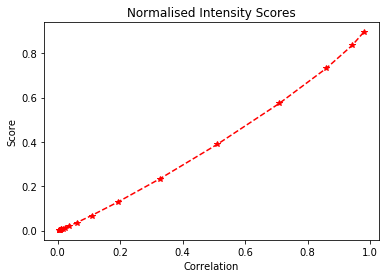

Plotting each heat map
Score: 0.894780273
Heatmap:



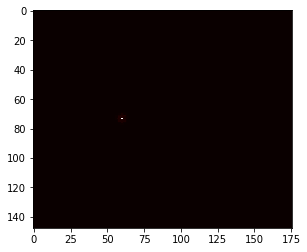

Score: 0.835596387678
Heatmap:



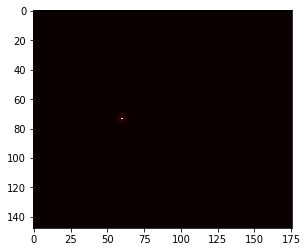

Score: 0.731553510833
Heatmap:



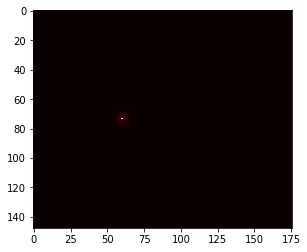

Score: 0.573401868328
Heatmap:



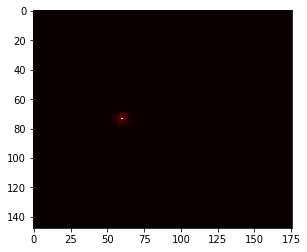

Score: 0.3895077579
Heatmap:



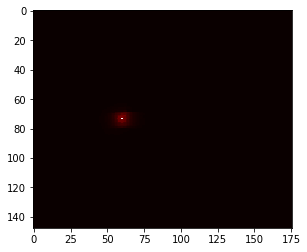

Score: 0.232597764659
Heatmap:



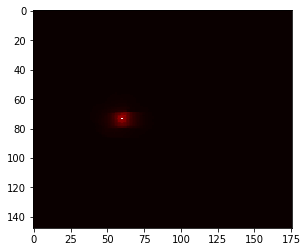

Score: 0.12767161894
Heatmap:



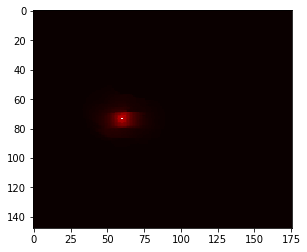

Score: 0.0675231055088
Heatmap:



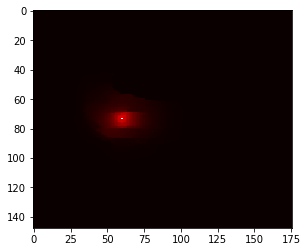

Score: 0.0357136952604
Heatmap:



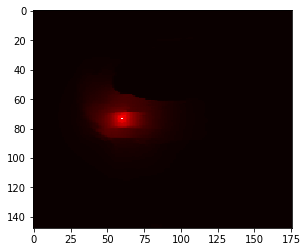

Score: 0.019895936249
Heatmap:



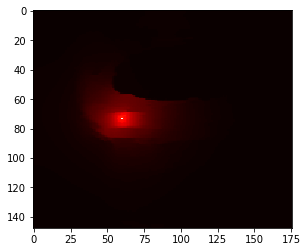

Score: 0.0122467886212
Heatmap:



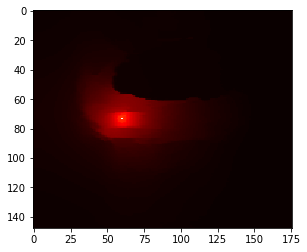

Score: 0.00823354733453
Heatmap:



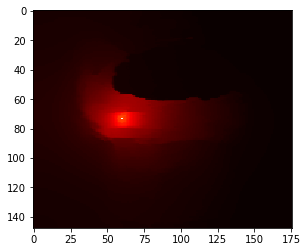

Score: 0.00491161375062
Heatmap:



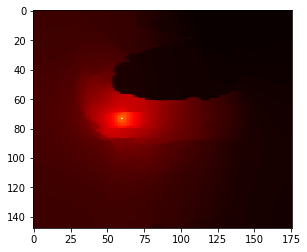

Score: 0.00460813240159
Heatmap:



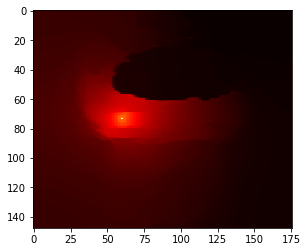

Score: 0.00356254333247
Heatmap:



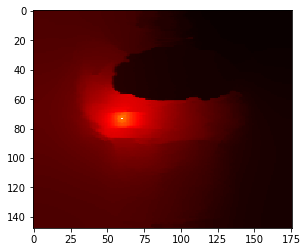

Score: 0.00318517388742
Heatmap:



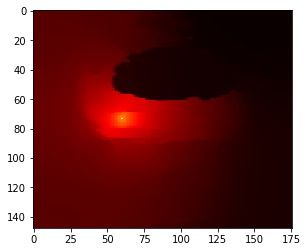

Score: 0.00281951345508
Heatmap:



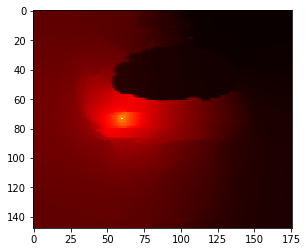

Score: 0.00263533293148
Heatmap:



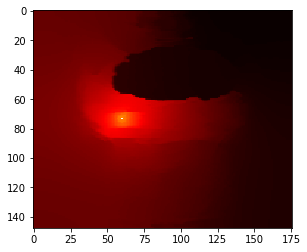

Score: 0.00267477499097
Heatmap:



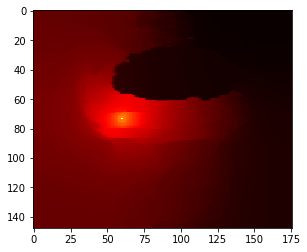

--------Seed [73, 92]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.981103275307
Score: 0.89275641756

alpha: 2^-1
Correlation: 0.948979405324
Score: 0.841103077231

alpha: 2^-2
Correlation: 0.879988258263
Score: 0.754897471871

alpha: 2^-3
Correlation: 0.755544404683
Score: 0.62367719106

alpha: 2^-4
Correlation: 0.574750642554
Score: 0.453731743943

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.376420453822
Score: 0.282230122346

alpha: 2^-6
Correlation: 0.214970338442
Score: 0.151885887359

alpha: 2^-7
Correlation: 0.112995974832
Score: 0.0746762409828

alpha: 2^-8
Correlation: 0.0584032264203
Score: 0.0359519944711

alpha: 2^-9
Correlation: 0.0319025937616
Score: 0.0183822756055

alpha: 2^-10
Correlation: 0.0192598667692
Score: 0.0105426689024

alpha: 2^-11
Correlation: 0.0136549458105
Score: 0.00726013220896

alpha: 2^-12
Correlation: 0.0106149398024
Score: 0.00555547400248

alpha: 2^-13
Correlation: 0.00897604022883
Score: 0.00466153104862

alpha:

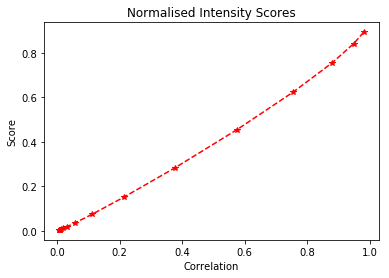

Plotting each heat map
Score: 0.89275641756
Heatmap:



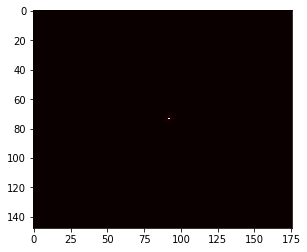

Score: 0.841103077231
Heatmap:



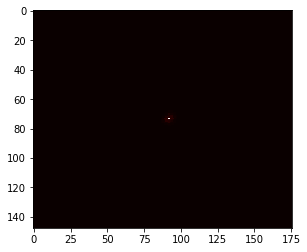

Score: 0.754897471871
Heatmap:



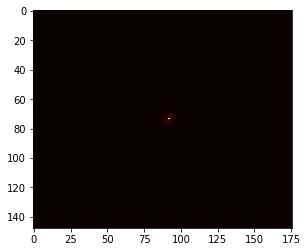

Score: 0.62367719106
Heatmap:



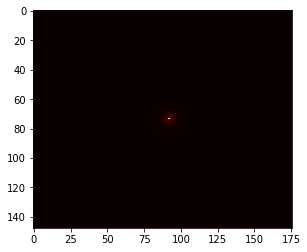

Score: 0.453731743943
Heatmap:



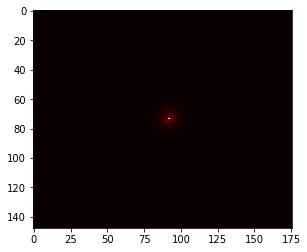

Score: 0.282230122346
Heatmap:



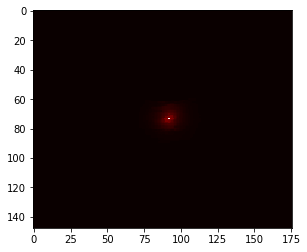

Score: 0.151885887359
Heatmap:



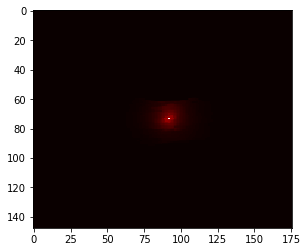

Score: 0.0746762409828
Heatmap:



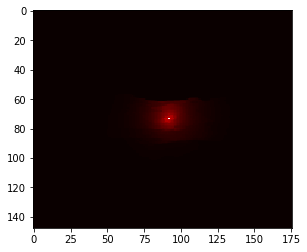

Score: 0.0359519944711
Heatmap:



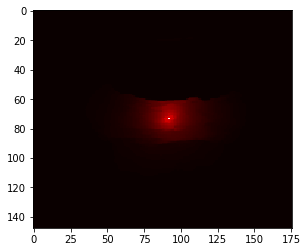

Score: 0.0183822756055
Heatmap:



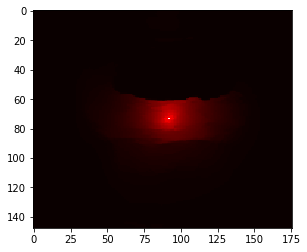

Score: 0.0105426689024
Heatmap:



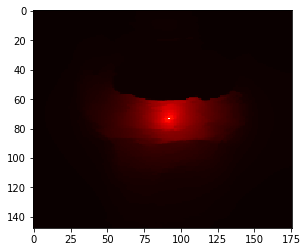

Score: 0.00726013220896
Heatmap:



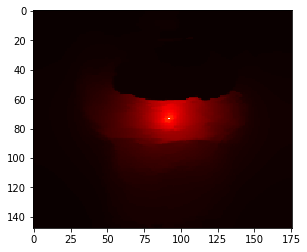

Score: 0.00555547400248
Heatmap:



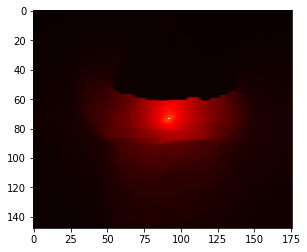

Score: 0.00466153104862
Heatmap:



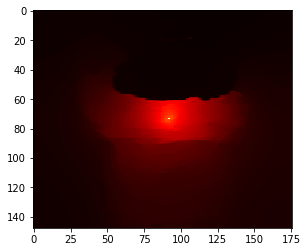

Score: 0.00418959797808
Heatmap:



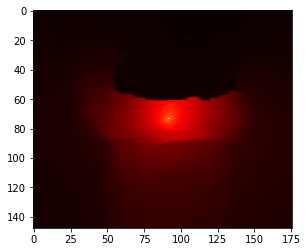

Score: 0.00374392292639
Heatmap:



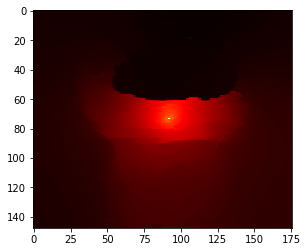

Score: 0.00384025528744
Heatmap:



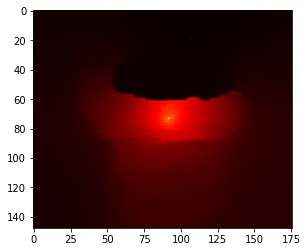

--------Seed [73, 124]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.976093046617
Score: 0.874316893334

alpha: 2^-1
Correlation: 0.933218987949
Score: 0.805854291761

alpha: 2^-2
Correlation: 0.840810269698
Score: 0.691977282114

alpha: 2^-3
Correlation: 0.689607742714
Score: 0.536428108542

alpha: 2^-4
Correlation: 0.504111260197
Score: 0.368758628507

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.328103791228
Score: 0.224804640459

alpha: 2^-6
Correlation: 0.193083283742
Score: 0.12332861082

alpha: 2^-7
Correlation: 0.107726379631
Score: 0.0639769773796

alpha: 2^-8
Correlation: 0.0605886136915
Score: 0.0335708933144

alpha: 2^-9
Correlation: 0.0364700119686
Score: 0.0190929419676

alpha: 2^-10
Correlation: 0.0239843419445
Score: 0.0120627538092

alpha: 2^-11
Correlation: 0.0169467442822
Score: 0.0082997737303

alpha: 2^-12
Correlation: 0.0119136910337
Score: 0.0057184107523

alpha: 2^-13
Correlation: 0.0096092824244
Score: 0.00457052395122

alpha: 

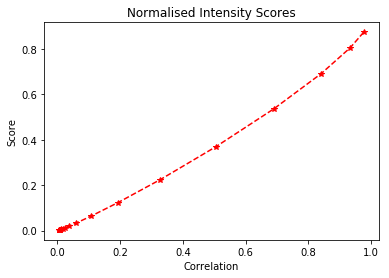

Plotting each heat map
Score: 0.874316893334
Heatmap:



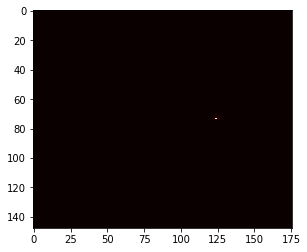

Score: 0.805854291761
Heatmap:



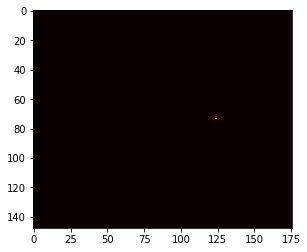

Score: 0.691977282114
Heatmap:



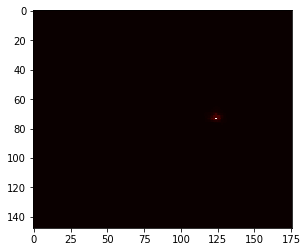

Score: 0.536428108542
Heatmap:



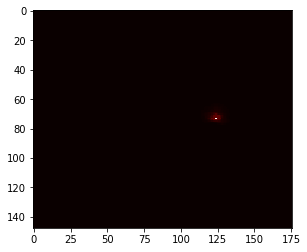

Score: 0.368758628507
Heatmap:



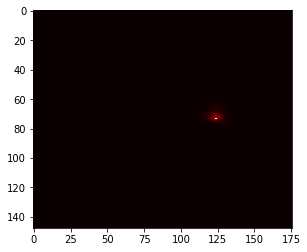

Score: 0.224804640459
Heatmap:



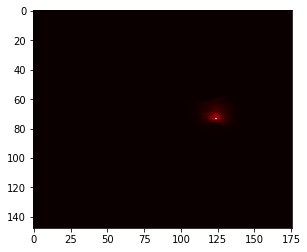

Score: 0.12332861082
Heatmap:



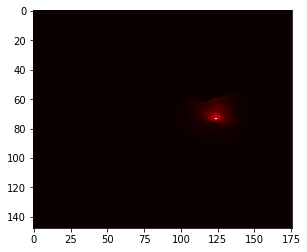

Score: 0.0639769773796
Heatmap:



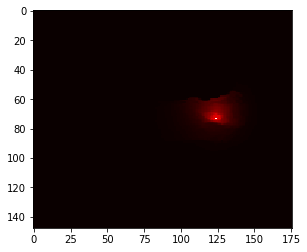

Score: 0.0335708933144
Heatmap:



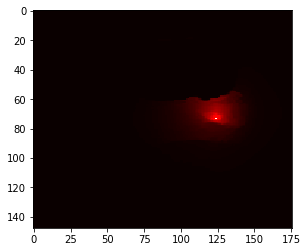

Score: 0.0190929419676
Heatmap:



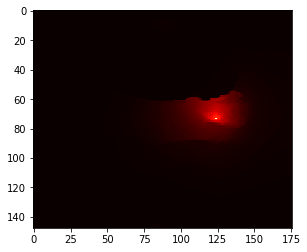

Score: 0.0120627538092
Heatmap:



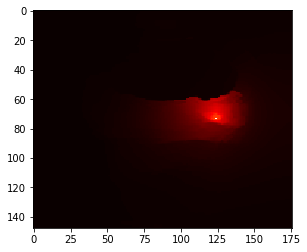

Score: 0.0082997737303
Heatmap:



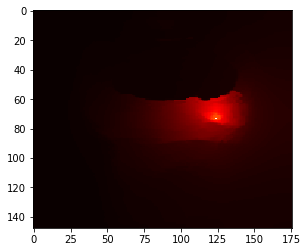

Score: 0.0057184107523
Heatmap:



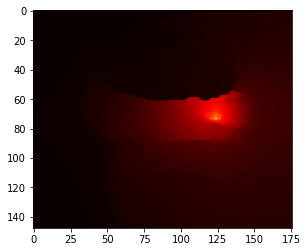

Score: 0.00457052395122
Heatmap:



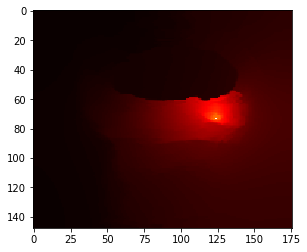

Score: 0.00379152940658
Heatmap:



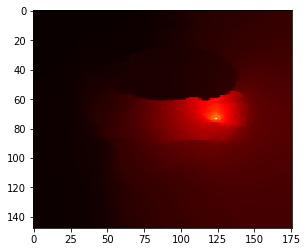

Score: 0.00336444404185
Heatmap:



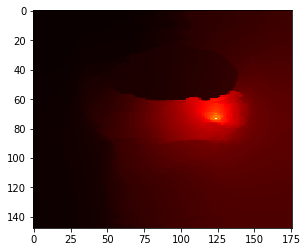

Score: 0.00298551481796
Heatmap:



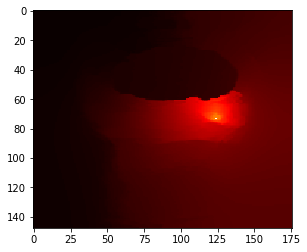

Score: 0.00282678665496
Heatmap:



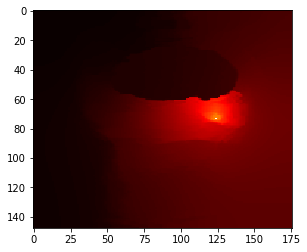

Score: 0.00290385071194
Heatmap:



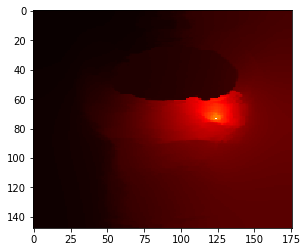

--------Seed [121, 60]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.979081650332
Score: 0.87161382432

alpha: 2^-1
Correlation: 0.943862106145
Score: 0.815609660481

alpha: 2^-2
Correlation: 0.869184042374
Score: 0.723785768666

alpha: 2^-3
Correlation: 0.738735773887
Score: 0.58917017097

alpha: 2^-4
Correlation: 0.56437239675
Score: 0.429609266908

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.386280841168
Score: 0.280281152452

alpha: 2^-6
Correlation: 0.243917061262
Score: 0.168910720267

alpha: 2^-7
Correlation: 0.147712239219
Score: 0.0979511048569

alpha: 2^-8
Correlation: 0.087664347552
Score: 0.0558886773516

alpha: 2^-9
Correlation: 0.0518028155791
Score: 0.0318883598997

alpha: 2^-10
Correlation: 0.0309295740441
Score: 0.018462779414

alpha: 2^-11
Correlation: 0.018429896141
Score: 0.0107024832545

alpha: 2^-12
Correlation: 0.0116764957591
Score: 0.00663731272397

alpha: 2^-13
Correlation: 0.0077447246536
Score: 0.00433300669095

alpha: 2^-1

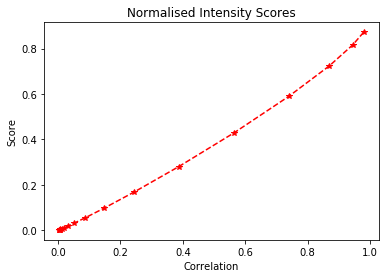

Plotting each heat map
Score: 0.87161382432
Heatmap:



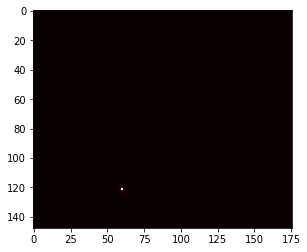

Score: 0.815609660481
Heatmap:



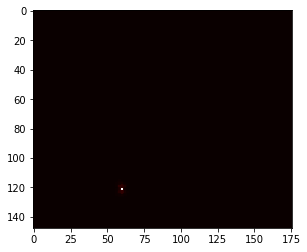

Score: 0.723785768666
Heatmap:



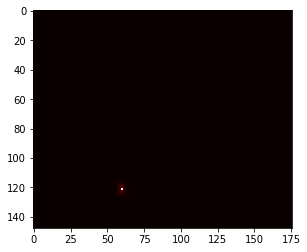

Score: 0.58917017097
Heatmap:



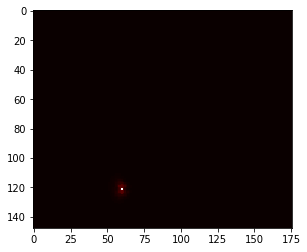

Score: 0.429609266908
Heatmap:



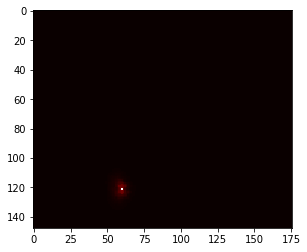

Score: 0.280281152452
Heatmap:



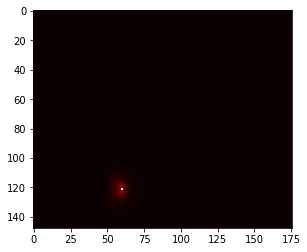

Score: 0.168910720267
Heatmap:



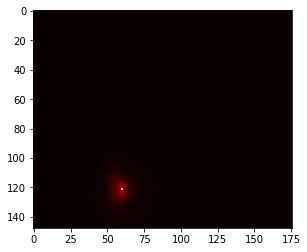

Score: 0.0979511048569
Heatmap:



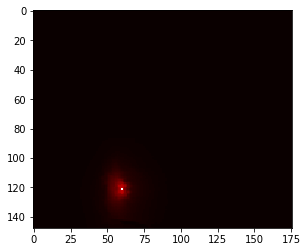

Score: 0.0558886773516
Heatmap:



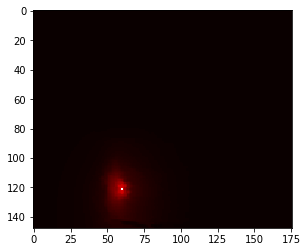

Score: 0.0318883598997
Heatmap:



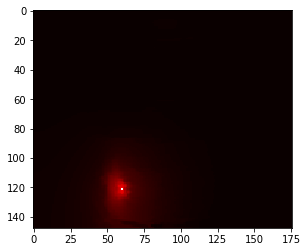

Score: 0.018462779414
Heatmap:



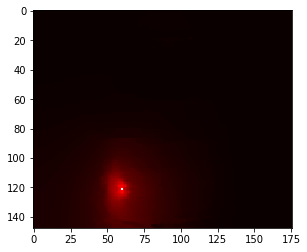

Score: 0.0107024832545
Heatmap:



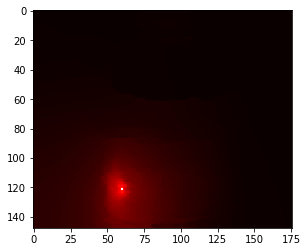

Score: 0.00663731272397
Heatmap:



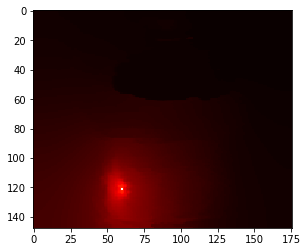

Score: 0.00433300669095
Heatmap:



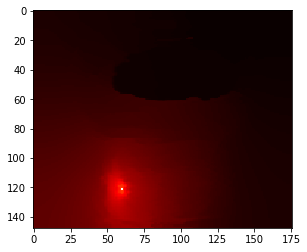

Score: 0.00339855582094
Heatmap:



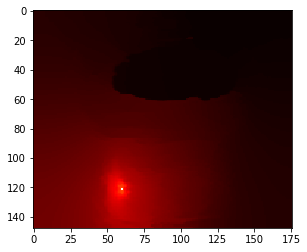

Score: 0.00276362819854
Heatmap:



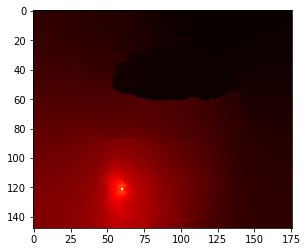

Score: 0.00238363930872
Heatmap:



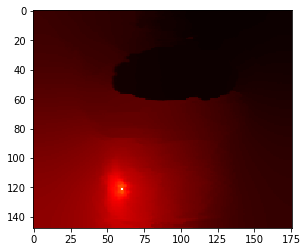

Score: 0.0025374124401
Heatmap:



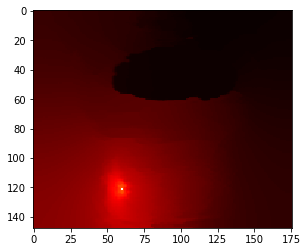

--------Seed [121, 92]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.980193973242
Score: 0.885238421885

alpha: 2^-1
Correlation: 0.947433865055
Score: 0.832726570835

alpha: 2^-2
Correlation: 0.878721905021
Score: 0.747307898158

alpha: 2^-3
Correlation: 0.758463625482
Score: 0.621326087962

alpha: 2^-4
Correlation: 0.589534365958
Score: 0.463599466803

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.406848030613
Score: 0.306443535202

alpha: 2^-6
Correlation: 0.252178180817
Score: 0.181646955961

alpha: 2^-7
Correlation: 0.143513248849
Score: 0.0986711741858

alpha: 2^-8
Correlation: 0.0763372050976
Score: 0.0499266485609

alpha: 2^-9
Correlation: 0.0397074227262
Score: 0.0246489112592

alpha: 2^-10
Correlation: 0.0221450876704
Score: 0.0131192383382

alpha: 2^-11
Correlation: 0.013329584859
Score: 0.00760199604131

alpha: 2^-12
Correlation: 0.00880180047347
Score: 0.00488854139021

alpha: 2^-13
Correlation: 0.00660738383072
Score: 0.00361792829346

alp

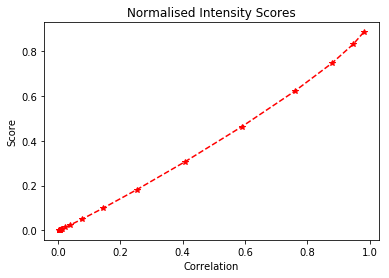

Plotting each heat map
Score: 0.885238421885
Heatmap:



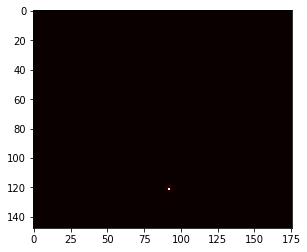

Score: 0.832726570835
Heatmap:



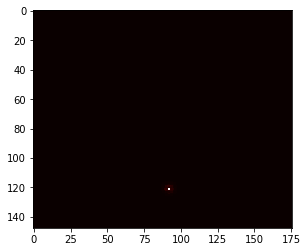

Score: 0.747307898158
Heatmap:



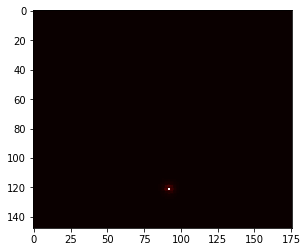

Score: 0.621326087962
Heatmap:



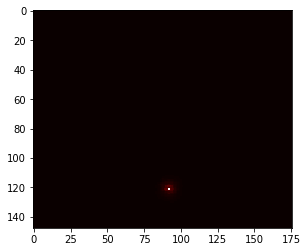

Score: 0.463599466803
Heatmap:



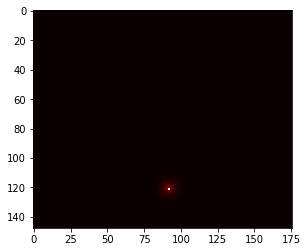

Score: 0.306443535202
Heatmap:



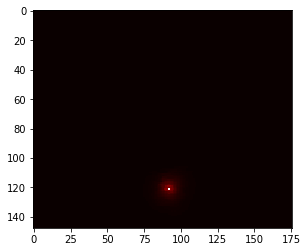

Score: 0.181646955961
Heatmap:



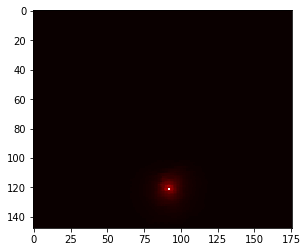

Score: 0.0986711741858
Heatmap:



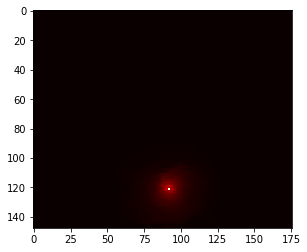

Score: 0.0499266485609
Heatmap:



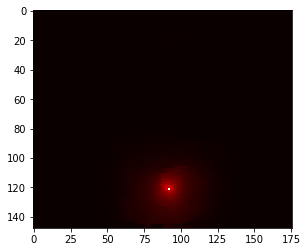

Score: 0.0246489112592
Heatmap:



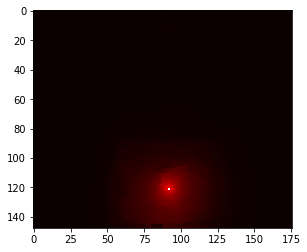

Score: 0.0131192383382
Heatmap:



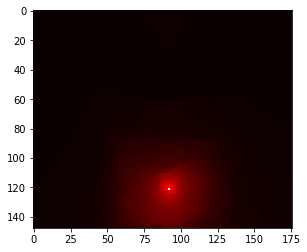

Score: 0.00760199604131
Heatmap:



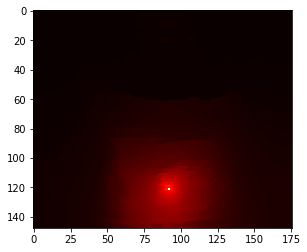

Score: 0.00488854139021
Heatmap:



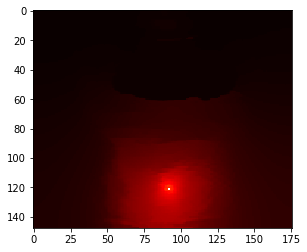

Score: 0.00361792829346
Heatmap:



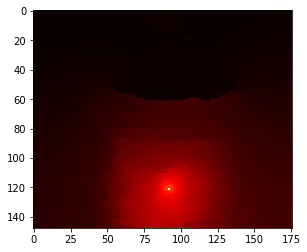

Score: 0.0029894745059
Heatmap:



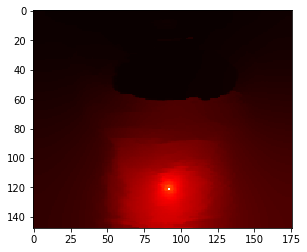

Score: 0.00265174710815
Heatmap:



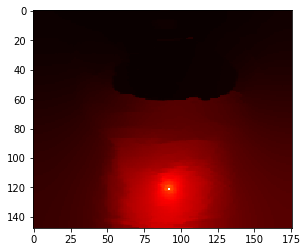

Score: 0.00248652863471
Heatmap:



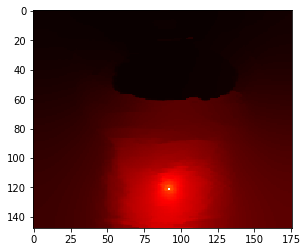

Score: 0.00235131476148
Heatmap:



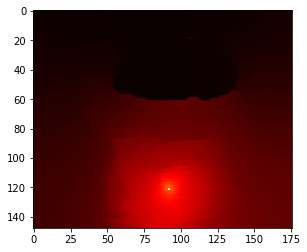

Score: 0.00227926870979
Heatmap:



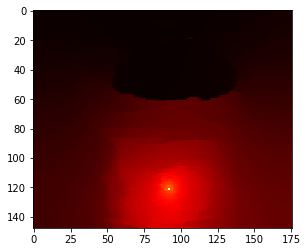

Score: 0.00235565106351
Heatmap:



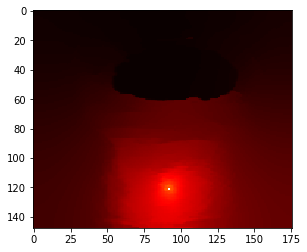

--------Seed [121, 124]
Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.979091763233
Score: 0.885020360872

alpha: 2^-1
Correlation: 0.942474772665
Score: 0.826321030679

alpha: 2^-2
Correlation: 0.862719997364
Score: 0.727243650771

alpha: 2^-3
Correlation: 0.724424114418
Score: 0.582879212119

alpha: 2^-4
Correlation: 0.545012433394
Score: 0.41695272194

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.370807090206
Score: 0.26970144989

alpha: 2^-6
Correlation: 0.235009742094
Score: 0.162887509791

alpha: 2^-7
Correlation: 0.142196830198
Score: 0.0942063340275

alpha: 2^-8
Correlation: 0.0833265179387
Score: 0.0529117195594

alpha: 2^-9
Correlation: 0.0470220690091
Score: 0.0286428618971

alpha: 2^-10
Correlation: 0.0251873634486
Score: 0.0146928249155

alpha: 2^-11
Correlation: 0.0134334193648
Score: 0.0075080218843

alpha: 2^-12
Correlation: 0.00807807550665
Score: 0.0043679023343

alpha: 2^-13
Correlation: 0.00538664028382
Score: 0.00284592996921

alpha

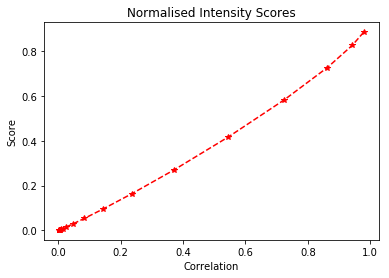

Plotting each heat map
Score: 0.885020360872
Heatmap:



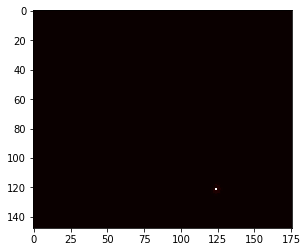

Score: 0.826321030679
Heatmap:



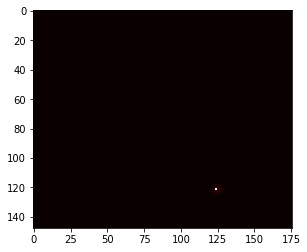

Score: 0.727243650771
Heatmap:



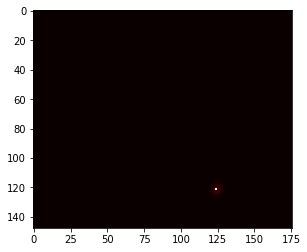

Score: 0.582879212119
Heatmap:



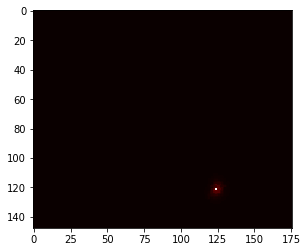

Score: 0.41695272194
Heatmap:



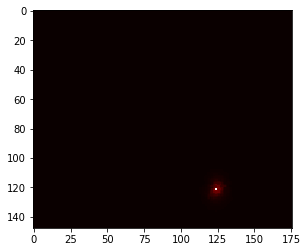

Score: 0.26970144989
Heatmap:



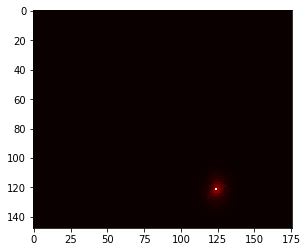

Score: 0.162887509791
Heatmap:



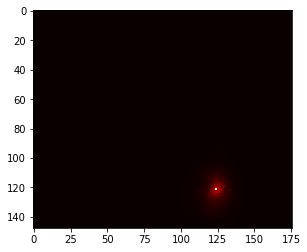

Score: 0.0942063340275
Heatmap:



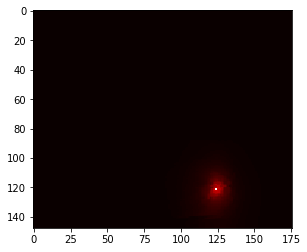

Score: 0.0529117195594
Heatmap:



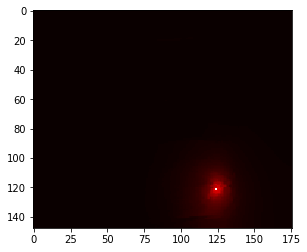

Score: 0.0286428618971
Heatmap:



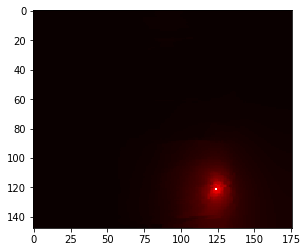

Score: 0.0146928249155
Heatmap:



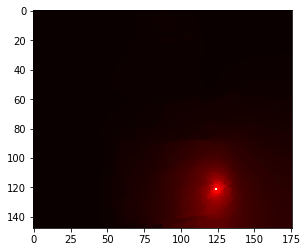

Score: 0.0075080218843
Heatmap:



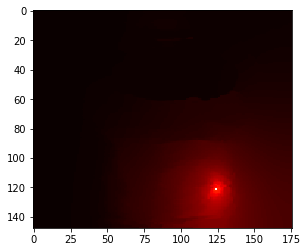

Score: 0.0043679023343
Heatmap:



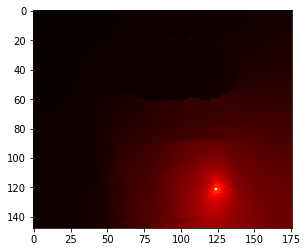

Score: 0.00284592996921
Heatmap:



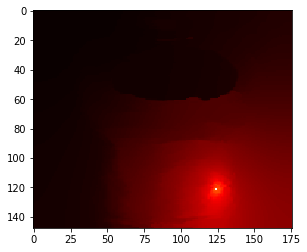

Score: 0.00209628750978
Heatmap:



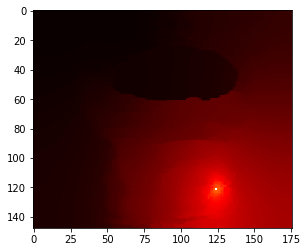

Score: 0.00177896520816
Heatmap:



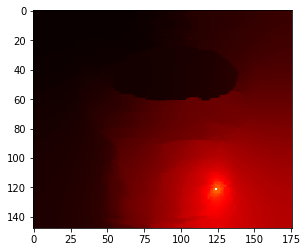

Score: 0.00164065500174
Heatmap:



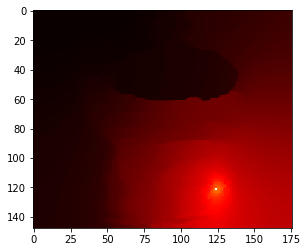

Score: 0.0015500348558
Heatmap:



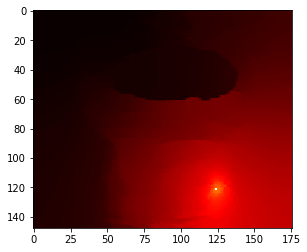

Score: 0.00148673304973
Heatmap:



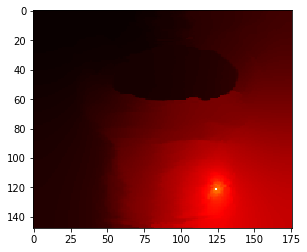

Score: 0.00147500908058
Heatmap:



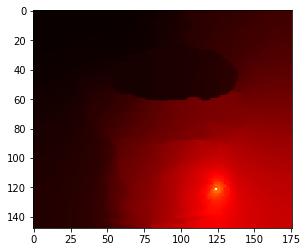

In [36]:
for elem in seedList[2:]:
    print('--------Seed ' + str(elem))
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    exponential = 0
    alpha = 2 ** exponential
    v = PRwalk(graph, alpha, s)
    normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
    # print(normalization)
    correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
    score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]

    print('Threshold: ' + str(1 / len(graph)))
    alphaList = []
    alphaList.append(alpha)

    correlationList = []
    correlationList.append(correlation)

    scoreList = []
    scoreList.append(score)

    valueList = []
    valueList.append(v)
    print('')
    print('alpha: 2^' + str(exponential))
    print('Correlation: ' + str(correlation))
    print('Score: ' + str(score))

    maxIterations = 29
    minIterations = 3
    for i in range(maxIterations):
        if correlation > 1 / len(graph):
            oldCorrelation = correlation
            exponential -= 1
            alpha = 2 ** exponential
            v = PRwalk(graph, alpha, s)
            normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
            correlation = \
                (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
            score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
            alphaList.append(alpha)
            correlationList.append(correlation)
            scoreList.append(score)
            valueList.append(v)
            print('')
            print('alpha: 2^' + str(exponential))
            print('Correlation: ' + str(correlation))
            print('Score: ' + str(score))
        if i == minIterations:
            print('')
            print('Starting correlation decrease check!')
        if i >= minIterations and oldCorrelation * .99 < correlation:
            break

    alphaListList.append(alphaList)
    correlationListList.append(correlationList)
    scoreListList.append(scoreList)
    valueListList.append(valueList)
    
    plt.plot(correlationList, scoreList, 'r*--')
    plt.xlabel('Correlation')
    plt.ylabel('Score')
    plt.title('Normalised Intensity Scores')
    plt.show()
    
    print('Plotting each heat map')
    for item in range(len(valueList)):
        heat = np.zeros(myImg.shape)
        for i in range(myImg.shape[0]):
            for j in range(myImg.shape[1]):
                heat[i][j] = valueList[item][i * myImg.shape[1] + j]
        print('Score: ' + str(scoreList[item]))
        print('Heatmap:\n')
        plt.imshow(heat, cmap='hot', interpolation='nearest')
        # plt.imshow(heat, cmap='hot', interpolation='nearest',alpha = .6)
        plt.show()

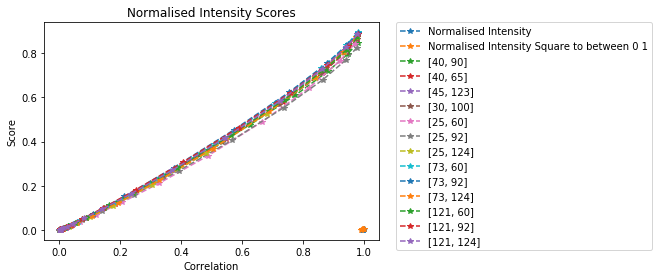

In [90]:
for i in range(len(correlationListList)):
    plt.plot(correlationListList[i], scoreListList[i], '*--')
plt.legend(seedList, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

In [91]:
import bcolz
def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

In [92]:
save_array(IMAGE + '/' + 'alphaListList.data', alphaListList)
save_array(IMAGE + '/' + 'correlationListList.data', correlationListList)
save_array(IMAGE + '/' + 'scoreListList.data', scoreListList)
save_array(IMAGE + '/' + 'valueListList.data', valueListList)
save_array(IMAGE + '/' + 'seedList.data', seedList[2:])

In [93]:
alphaListListRecovered = load_array(IMAGE + '/' + 'alphaListList.data')
correlationListListRecovered = load_array(IMAGE + '/' + 'correlationListList.data')
scoreListListRecovered = load_array(IMAGE + '/' + 'scoreListList.data')
valueListListRecovered = load_array(IMAGE + '/' + 'valueListList.data')
seedListRecovered = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1']
seedListRecovered[2:] = load_array(IMAGE + '/' + 'seedList.data')

Print with saved arrays for future usage


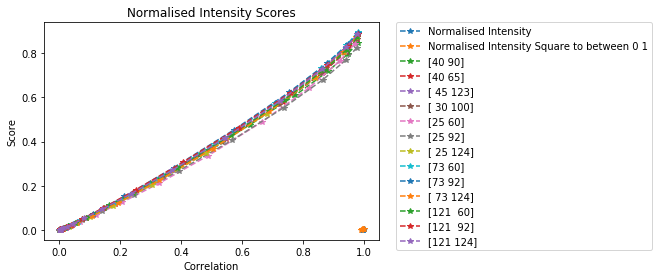

In [94]:
print('Print with saved arrays for future usage')
for i in range(len(correlationListListRecovered)):
    plt.plot(correlationListListRecovered[i], scoreListListRecovered[i], '*--')
plt.legend(seedListRecovered, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

### End

In [ ]:
Ps = np.copy(v[:,0])
if(v[point] <= 0):
    print('Negative!')
    Ps = -1 * Ps
for i in range(len(Ps)):
    if(Ps[i] < 0):
        Ps[i] = 0
Ps = Ps / sum(Ps)
# Flattening image
imgArray = np.zeros(myImg.shape[0] * myImg.shape[1])
for i in range(myImg.shape[0]):
    for j in range(myImg.shape[1]):
        imgArray[i * myImg.shape[1] + j] = myImg[i][j]
LValues = np.argsort(-Ps)
numerator = 0
denominator = 0
for i in range(3500):
    numerator += Ps[LValues[i]] * imgArray[LValues[i]]
    denominator += Ps[LValues[i]]
score = numerator / math.sqrt(denominator)
scoreList.append(score)
print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(score))

In [ ]:
scoreList = []
for elem in SeedList[0]:
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    alpha = 10
    v = PRwalk(graph, alpha, s)
    normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
    # print(normalization)
    correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
    print(correlation)

    while correlation > 1 / len(graph):
        alpha = alpha/2
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        print(correlation)
        # score these v by the quadratic form of the laplacian and their correlation and then decide which ones to keep
        
    Ps = np.copy(v[:,0])
    if(v[point] <= 0):
        print('Negative!')
        Ps = -1 * Ps
    for i in range(len(Ps)):
        if(Ps[i] < 0):
            Ps[i] = 0
    Ps = Ps / sum(Ps)
    # Flattening image
    imgArray = np.zeros(myImg.shape[0] * myImg.shape[1])
    for i in range(myImg.shape[0]):
        for j in range(myImg.shape[1]):
            imgArray[i * myImg.shape[1] + j] = myImg[i][j]
    LValues = np.argsort(-Ps)
    numerator = 0
    denominator = 0
    for i in range(3500):
        numerator += Ps[LValues[i]] * imgArray[LValues[i]]
        denominator += Ps[LValues[i]]
    score = numerator / math.sqrt(denominator)
    scoreList.append(score)
    print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(score))
copyScoreList = np.copy(scoreList)
argSortList = np.argsort(-copyScoreList)
numpySeedList = np.asarray(SeedList)
scoreOverall = []
pointsOverall = []
for i in range(len(copyScoreList)):
    elem = numpySeedList[list(argSortList)][i]
    print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(copyScoreList[list(argSortList)][i]))
    pointsOverall.append(copyScoreList[list(argSortList)][i])
    scoreOverall.append([elem[0], elem[1], 1])

0.999640434855
0.998618721697
0.995257055019
0.985341444266
0.960152279998
0.907531413025
0.814664973106
0.679071026739
0.514036600204
0.346753307414
0.20280993974
0.0994691106853
0.0417767551779
0.0167920765851
0.00743927148161


In [5]:
# 0cc6fc725d4b8818415ddc06823fce98
myImg = np.asarray(imread("0cc6fc725d4b8818415ddc06823fce98/0cc6fc725d4b8818415ddc06823fce98.aps.jpg"), dtype=np.int)
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
print(myImg.shape)
# print(np.round(graph, decimals=3))
seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
seed[70 * myImg.shape[1] + 78][0] = 1 # Example seed
# seed[70 * myImg.shape[1] + 70][0] = 1 # Example middle seed
SeedList = []
for i in range(30, 111, 16):
    for j in range(50, 111, 20):
        SeedList.append([i,j])
scoreList = []
for elem in SeedList:
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    alpha = .001
    v = PRwalk(graph, alpha, s)
    normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
    # print(normalization)
    correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
    # print(correlation)

    while correlation < 1 / len(graph):
        alpha = 2 * alpha
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        print(correlation)
        
    Ps = np.copy(v[:,0])
    if(v[point] <= 0):
        print('Negative!')
        Ps = -1 * Ps
    for i in range(len(Ps)):
        if(Ps[i] < 0):
            Ps[i] = 0
    Ps = Ps / sum(Ps)
    # Flattening image
    imgArray = np.zeros(myImg.shape[0] * myImg.shape[1])
    for i in range(myImg.shape[0]):
        for j in range(myImg.shape[1]):
            imgArray[i * myImg.shape[1] + j] = myImg[i][j]
    LValues = np.argsort(-Ps)
    numerator = 0
    denominator = 0
    for i in range(3500):
        numerator += Ps[LValues[i]] * imgArray[LValues[i]]
        denominator += Ps[LValues[i]]
    score = numerator / math.sqrt(denominator)
    scoreList.append(score)
    # print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(score))
copyScoreList = np.copy(scoreList)
argSortList = np.argsort(-copyScoreList)
numpySeedList = np.asarray(SeedList)
for i in range(len(copyScoreList)):
    elem = numpySeedList[list(argSortList)][i]
    print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(copyScoreList[list(argSortList)][i]))
    pointsOverall.append(copyScoreList[list(argSortList)][i])
    scoreOverall.append([elem[0], elem[1], 2])

(140, 156)
Point: [110, 90] Score: 152.896772214
Point: [110, 70] Score: 149.868111538
Point: [94, 90] Score: 141.653859712
Point: [94, 50] Score: 140.792108337
Point: [94, 70] Score: 140.46532555
Point: [110, 50] Score: 136.274417118
Point: [94, 110] Score: 128.320182021
Point: [110, 110] Score: 125.314297329
Point: [78, 70] Score: 117.8884876
Point: [46, 70] Score: 117.239597281
Point: [30, 70] Score: 116.008172021
Point: [62, 70] Score: 114.797126183
Point: [46, 90] Score: 114.245595076
Point: [30, 90] Score: 111.521018836
Point: [78, 90] Score: 111.443375422
Point: [62, 90] Score: 111.066523328
Point: [46, 50] Score: 104.523121962
Point: [46, 110] Score: 104.283104645
Point: [62, 110] Score: 102.051415894
Point: [62, 50] Score: 97.1582942986
Point: [78, 50] Score: 89.848457236
Point: [78, 110] Score: 85.7691354018
Point: [30, 110] Score: 84.7956813339
Point: [30, 50] Score: 71.892486473


In [8]:
pointsOverall

[94.056283058034168,
 86.831637541840607,
 78.276926224192394,
 78.247805975229781,
 76.087615680475722,
 72.841199380610803,
 71.057359870395217,
 70.914683233100959,
 70.853892357121154,
 68.787719006536435,
 55.802226664234539,
 51.828761284756311,
 50.123825333618406,
 45.86125608047363,
 42.81951174499747,
 21.833959001906724,
 21.472224428726996,
 21.390891073556194,
 21.277633917400983,
 21.197407693776462,
 21.11257017878259,
 20.728240570541782,
 19.908669696916579,
 19.666650455979063,
 152.89677221371866,
 149.86811153815964,
 141.65385971235162,
 140.79210833745898,
 140.46532554988195,
 136.2744171178866,
 128.32018202060593,
 125.31429732870855,
 117.88848760039568,
 117.23959728091964,
 116.00817202071316,
 114.79712618294602,
 114.24559507554318,
 111.52101883556846,
 111.44337542186005,
 111.06652332786176,
 104.52312196164915,
 104.28310464542092,
 102.05141589431582,
 97.158294298567938,
 89.848457236029276,
 85.769135401804789,
 84.795681333940308,
 71.8924864729628

In [15]:
copyScoreList3 = np.copy(pointsOverall)
argSortList = np.argsort(-copyScoreList3)
# copyScoreList3 = (copyScoreList3 - np.mean(copyScoreList3)) / np.std(copyScoreList3)
plt.stem(range(1, len(copyScoreList3) + 1),copyScoreList3[list(argSortList)] , basefmt=" ")
# plt.axis([0, 25, 0, 100])
plt.xlabel('Point')
plt.ylabel('Score')
# plt.show()
# plt.savefig('DifferentSeedsPlotNormalized(N(0,1)).eps')
plt.savefig('DifferentSeedsAllPlot.eps')

In [3]:
# '''
myImg = np.asarray(imread("1a10297e6c3101af33003e6c4f846f47/1a10297e6c3101af33003e6c4f846f47.aps.jpg"), dtype=np.int)
# print(myImg)
# print(myImg.shape) # 148 row, 176 columns
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
# seed[40 * myImg.shape[1] + 90][0] = 1 # Example seed
seed[74 * myImg.shape[1] + 88][0] = 1 # Example middle seed
'''
myImg = np.asarray(imread("3a8696b99b2d1b28be62389d48d697be/3a8696b99b2d1b28be62389d48d697be.aps.jpg"), dtype=np.int)
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
print(myImg.shape)
# print(np.round(graph, decimals=3))
seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
# seed[20 * myImg.shape[1] + 65][0] = 1 # Example seed
seed[70 * myImg.shape[1] + 70][0] = 1 # Example middle seed

myImg = np.asarray(imread("0cc6fc725d4b8818415ddc06823fce98.aps.jpg"), dtype=np.int)
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
print(myImg.shape)
# print(np.round(graph, decimals=3))
seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
seed[70 * myImg.shape[1] + 78][0] = 1 # Example seed
# seed[70 * myImg.shape[1] + 70][0] = 1 # Example middle seed
'''

'\nmyImg = np.asarray(imread("3a8696b99b2d1b28be62389d48d697be/3a8696b99b2d1b28be62389d48d697be.aps.jpg"), dtype=np.int)\ngraph = fully_connected_e_neighbour_graph(myImg, 5, 3)\nprint(myImg.shape)\n# print(np.round(graph, decimals=3))\nseed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))\n# seed[20 * myImg.shape[1] + 65][0] = 1 # Example seed\nseed[70 * myImg.shape[1] + 70][0] = 1 # Example middle seed\n\nmyImg = np.asarray(imread("0cc6fc725d4b8818415ddc06823fce98.aps.jpg"), dtype=np.int)\ngraph = fully_connected_e_neighbour_graph(myImg, 5, 3)\nprint(myImg.shape)\n# print(np.round(graph, decimals=3))\nseed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))\nseed[70 * myImg.shape[1] + 78][0] = 1 # Example seed\n# seed[70 * myImg.shape[1] + 70][0] = 1 # Example middle seed\n'

In [11]:
SeedList = [[40,90],[40,65],[45,123],[30,100]]
for i in range(25, 122, 24):
    for j in range(60, 125, 21):
        SeedList.append([i,j])
SeedList

[[40, 90],
 [40, 65],
 [45, 123],
 [30, 100],
 [25, 60],
 [25, 81],
 [25, 102],
 [25, 123],
 [49, 60],
 [49, 81],
 [49, 102],
 [49, 123],
 [73, 60],
 [73, 81],
 [73, 102],
 [73, 123],
 [97, 60],
 [97, 81],
 [97, 102],
 [97, 123],
 [121, 60],
 [121, 81],
 [121, 102],
 [121, 123]]

In [90]:
# SeedList = [[25,60],[25,130],[120,60],[120,130]]
# SeedList = [[120,125]]
scoreList = []
for elem in SeedList:
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    alpha = .001
    v = PRwalk(graph, alpha, s)
    normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
    # print(normalization)
    correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
    # print(correlation)

    while correlation < 1 / len(graph):
        alpha = 2 * alpha
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        print(correlation)
        
    Ps = np.copy(v[:,0])
    if(v[point] <= 0):
        print('Negative!')
        Ps = -1 * Ps
    for i in range(len(Ps)):
        if(Ps[i] < 0):
            Ps[i] = 0
    Ps = Ps / sum(Ps)
    # Flattening image
    imgArray = np.zeros(myImg.shape[0] * myImg.shape[1])
    for i in range(myImg.shape[0]):
        for j in range(myImg.shape[1]):
            imgArray[i * myImg.shape[1] + j] = myImg[i][j]
    LValues = np.argsort(-Ps)
    numerator = 0
    denominator = 0
    for i in range(3500):
        numerator += Ps[LValues[i]] * imgArray[LValues[i]]
        denominator += Ps[LValues[i]]
    score = numerator / math.sqrt(denominator)
    scoreList.append(score)
    print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(score))

KeyboardInterrupt: 

In [40]:
copyScoreList = np.copy(scoreList)
argSortList = np.argsort(-copyScoreList)

In [69]:
plt.stem(range(1, len(copyScoreList) + 1),copyScoreList[list(argSortList)] , basefmt=" ")
plt.axis([0, 25, 0, 100])
plt.xlabel('Point')
plt.ylabel('Score')
# plt.show()
plt.savefig('DifferentSeedsPlot.eps')

In [57]:
numpySeedList = np.asarray(SeedList)
for i in range(len(copyScoreList)):
    elem = numpySeedList[list(argSortList)][i]
    print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(copyScoreList[list(argSortList)][i]))

Point: [121, 81] Score: 94.056283058
Point: [121, 102] Score: 86.8316375418
Point: [73, 102] Score: 78.2769262242
Point: [73, 81] Score: 78.2478059752
Point: [97, 81] Score: 76.0876156805
Point: [97, 60] Score: 72.8411993806
Point: [121, 60] Score: 71.0573598704
Point: [73, 60] Score: 70.9146832331
Point: [73, 123] Score: 70.8538923571
Point: [97, 102] Score: 68.7877190065
Point: [25, 81] Score: 55.8022266642
Point: [121, 123] Score: 51.8287612848
Point: [25, 60] Score: 50.1238253336
Point: [97, 123] Score: 45.8612560805
Point: [25, 123] Score: 42.819511745
Point: [25, 102] Score: 21.8339590019
Point: [40, 65] Score: 21.4722244287
Point: [30, 100] Score: 21.3908910736
Point: [40, 90] Score: 21.2776339174
Point: [49, 81] Score: 21.1974076938
Point: [49, 60] Score: 21.1125701788
Point: [49, 102] Score: 20.7282405705
Point: [45, 123] Score: 19.9086696969
Point: [49, 123] Score: 19.666650456


In [89]:
copyScoreList2 = np.copy(scoreList)
copyScoreList2 = (copyScoreList2 - np.mean(copyScoreList2)) / np.std(copyScoreList2)
plt.stem(range(1, len(copyScoreList2) + 1),copyScoreList2[list(argSortList)] , basefmt=" ")
# plt.axis([0, 25, 0, 100])
plt.xlabel('Point')
plt.ylabel('Score')
# plt.show()
plt.savefig('DifferentSeedsPlotNormalized(N(0,1)).eps')

In [79]:
[L, D] = laplacian(graph)
s = orthogonalize(D, seed)
s = normalize(D, s)
alpha = .001
v = PRwalk(graph, alpha, s)
normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
print(normalization)
correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
print(correlation)

while correlation < 1 / len(graph):
    alpha = 2 * alpha
    v = PRwalk(graph, alpha, s)
    normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
    correlation = \
        (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
    print(correlation)

109.370271349
0.0235638565228


In [91]:
scoreList

[]

In [87]:
v[74 * myImg.shape[1] + 88]
min(v)

array([-0.00625094])

In [85]:
Ps = np.copy(v[:,0])
for i in range(len(Ps)):
    if(Ps[i] < 0):
        Ps[i] = 0
print(Ps[74 * myImg.shape[1] + 88])
Ps = Ps / sum(Ps)
# Flattening image
imgArray = np.zeros(myImg.shape[0] * myImg.shape[1])
for i in range(myImg.shape[0]):
    for j in range(myImg.shape[1]):
        imgArray[i * myImg.shape[1] + j] = myImg[i][j]
LValues = np.argsort(-Ps)

0.0
0.380390937484


In [84]:
sum(Ps)

1.0000000000000009

In [75]:
plt.plot(Ps[list(LValues)])
plt.axis([0, 3500, 0, .0005])
# plt.show()
plt.savefig('ScoreCalculation/SeedOutThreadProbabilitySortingZoomed.eps')
# 1a10297e6c3101af33003e6c4f846f47
# L is chosen to be 2500 for seed in  threat
# L is chosen to be 3500 for seed out threat
# 3a8696b99b2d1b28be62389d48d697be
# L is chosen to be 2500 for seed in  threat
# L is chosen to be 3500 for seed out threat

In [86]:
numerator = 0
denominator = 0
for i in range(3500):
    numerator += Ps[LValues[i]] * imgArray[LValues[i]]
    denominator += Ps[LValues[i]]
score = numerator / math.sqrt(denominator)
score
# 1a10297e6c3101af33003e6c4f846f47
# Score for seed in  threat is 20.92396
# Score for seed out threat is 78.89822
# 3a8696b99b2d1b28be62389d48d697be
# Score for seed in  threat is 47.65544
# Score for seed out threat is 96.64295

78.898223757060279

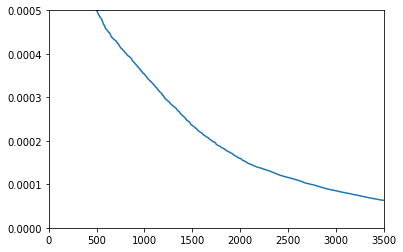

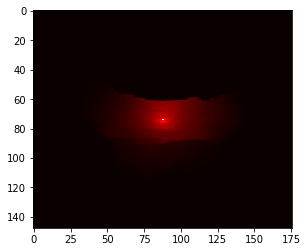

In [47]:
heat = np.zeros(myImg.shape)
for i in range(myImg.shape[0]):
    for j in range(myImg.shape[1]):
        heat[i][j] = Ps[i * myImg.shape[1] + j]
plt.show()
plt.imshow(heat, cmap='hot', interpolation='nearest')
plt.show()

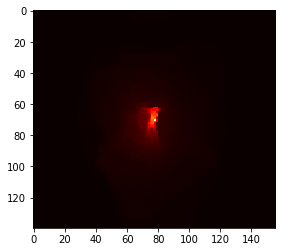

In [122]:
heat = np.zeros(myImg.shape)
for i in range(myImg.shape[0]):
    for j in range(myImg.shape[1]):
        heat[i][j] = v[i * myImg.shape[1] + j]
# plt.show()
# plt.imshow(myImg)
# plt.imshow(heat, cmap='hot', interpolation='nearest')
# plt.imshow(heat, cmap='hot', interpolation='nearest', alpha = .65)
# plt.savefig('0cc6fc725d4b8818415ddc06823fce98/RW_cropped_superimposed_MiddlePointSeed.eps')

(140, 156)
(660, 512)


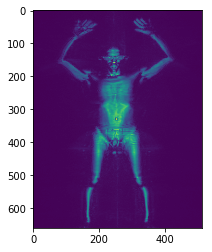

In [124]:
data = rd.read_data("0cc6fc725d4b8818415ddc06823fce98/0cc6fc725d4b8818415ddc06823fce98.aps")
img = np.rot90(data[:, :, 0])
myImgFull = np.asarray(img, dtype=np.double)
heat = np.zeros(myImgFull.shape)
for i in range(myImg.shape[0]):
    for j in range(myImg.shape[1]):
        heat[199 + i][180 + j] = v[i * myImg.shape[1] + j]
print(myImg.shape)
print(heat.shape)
plt.show()
plt.imshow(myImgFull)
# plt.savefig('0cc6fc725d4b8818415ddc06823fce98/FullImage.eps')
plt.imshow(heat, cmap='hot', interpolation='nearest',alpha = .6)
plt.savefig('0cc6fc725d4b8818415ddc06823fce98/RW_FullImage.eps')